# Bias correcting daily WRF precipitation using a probabilistic neural network  

### Import required packages 

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import geopandas
import os, shutil, time, pdb, random
import scipy.stats as stats 
import scipy

from IPython.display import clear_output

from math import pi
from datetime import datetime
from collections import OrderedDict
import pickle

import torch
from torch.utils.data import TensorDataset, DataLoader 

from importlib import reload
from models import *
from utils import *
from runmanager import *
from experiment import *
from plot_utils import *
from preprocessing_utils import *

# from shapely.geometry import box, mapping
import descartes

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rc_file_defaults()
%matplotlib inline

import rasterio
from rasterio.plot import show

import seaborn as sns
from tabulate import tabulate
# sns.set_theme()

pd.options.display.max_columns = None

np.random.seed(4)

%load_ext autoreload
%autoreload 2

# Detect device.
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [2]:
# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

### Import data

In [3]:
# Parameters
start="1998-01-01"
end="2007-12-31"

TRAIN_PATH = "../data/pickle/df_stations_all_nonzero_extended.pkl"
TEST_PATH = "../data/pickle/df_stations_val_all_nonzero_extended.pkl"

In [4]:
st =     (import_dataframe(TRAIN_PATH)
    .pipe(drop_df_NaNs, series='Prec')
    .pipe(clip_time_period, start, end)
    )  

st['Year'] = pd.DatetimeIndex(pd.to_datetime(st['Date'], format='%Y-%m-%d')).year
st['month'] = pd.DatetimeIndex(pd.to_datetime(st['Date'], format='%Y-%m-%d')).month
st['season'] = st.apply(season_apply, axis=1) 

st = FilterCompleteStationYears(st)

# st['set'] = "train" 

# st_val = (import_dataframe(TEST_PATH) # Import dataframe
#     .pipe(drop_df_NaNs, series='Prec') # Drop NaNs
#     .pipe(clip_time_period, start, end) # Clip data temporally 
# )

# st_val['set'] = "test"

In [13]:
def sort_by_quantile(st):
    
    QM_data = {}
    list_stations = st['Station'].unique()
    
    for i, s in enumerate(list_stations):
        QM_data[s] = st[st['Station']==s].sort_values(by='wrf_prcp')
        QM_data[s]['Prec'] = QM_data[s]['Prec'].sort_values().values

        if i == 0:
            QM_df = QM_data[s]
        else:
            QM_df = QM_df.append(QM_data[s])

    QM_df.reset_index(drop=True)
    
    return QM_df

In [14]:
sort_by_quantile_flag = False
if sort_by_quantile_flag:
    st = sort_by_quantile(st)

In [15]:
# List bias-corrected and non-bias-corrected stations
bc_stations = list_bc_stations(st)
non_bc_stations = disjunctive_union_lists(st['Station'].unique(), bc_stations)

In [16]:
# Append validation stations to training 
# st = st.append(st_val)

In [17]:
# Filter by basin
filter_by_basin_flag = False
if filter_by_basin_flag:
    st = st[st['Basin']=='Sutlej']

In [18]:
# Add observed precipitation value from previous day
st['obs_yesterday'] = st.groupby('Station')['Prec'].shift(1)
st.dropna(inplace=True)

### Split data into held out sets for single model run

We will start by defining the set of stations to be split into training, validation and test held out sets.

In [19]:
# If True, validation and test sets will only include bias corrected stations.
split_bias_corrected_only = True

# Set of stations to be split into training, validation and test held out sets.
if split_bias_corrected_only:
    st_names = list(set(bc_stations) & set(st['Station'].unique()))
else:
    st_names = st['Station'][st['set']=='train'].unique()

# st_names_test = st['Station'][st['set']=='test'].unique()
st_names = np.array(st_names)

In [20]:
# Random selection of locations for train and test
np.random.shuffle(st_names)

split = round(len(st_names) * 0.2)

st_names_dict = {}

non_bc_st_names = non_bc_stations # list(set(list(st['Station'].unique())) - set(list(st_names)))

# st_names_dict['train'] = list(st_names)#[:split*4])
# st_names_dict['val'] = list(st_names_test)#[split*4:])
# st_names_dict['test'] = list(st_names_test)

st_names_dict['train'] = list(st_names[:split*3])    
st_names_dict['val'] = list(st_names[split*3:split*4])
st_names_dict['test'] = list(st_names[split*4:split*5]) 

include_non_bc_stations = True

if include_non_bc_stations:
    st_names_dict['train'] += non_bc_st_names

print("%s stations used for training, %s used for validation, and %s used testing" % (len(st_names_dict['train']), len(st_names_dict['val']), len(st_names_dict['test'])))

44 stations used for training, 6 used for validation, and 6 used testing


In [91]:
# val_stations = ['Pandoh', 'Banjar', 'Bhuntar', 'Larji', 'Sainj', 'Janjehl',
#                 'Hamirpur', 'Nadaun', 'Sujanpur', 'Dehra', 'Kangra', 'Palampur',
#                 'Sadar-Mandi', 'Jogindernagar', 'Sarkaghat']

# train_stations = ['Sundernagar', 'BanjarIMD', 'Bharmaur', 'Churah', 'Kalatop',
#                     'Salooni', 'Rohru', 'Jubbal', 'Kothai', 'Nahan', 'Paonta Sahib',
#                     'Rakuna', 'Pachhad', 'Dadahu', 'Dhaula Kuan', 'Kandaghat', 'Suni',
#                     'Rampur', 'Kasol', 'Bhakra', 'Sadar-Bilarspur', 'Ghumarwin',
#                     'Bhoranj', 'Karsog', 'Theog', 'Kumarsain', 'Mashobra', 'Arki',
#                     'RampurIMD', 'SuniIMD', 'Berthin', 'Bharatgarh', 'Daslehra',
#                     'Ganguwal', 'Ghanauli', 'Kotata', 'Lohard', 'Naina Devi', 'Nangal',
#                     'Olinda', 'Swaghat', 'Kalpa', 'Kaza']

# test_stations = val_stations

# train_stations = non_bc_stations #bc_stations
# val_stations = bc_stations #non_bc_stations
# test_stations = bc_stations #non_bc_stations

# st_names_dict['train'] = train_stations
# st_names_dict['val'] = val_stations
# st_names_dict['test'] = test_stations

# print("%s stations used for training, %s used for validation, and %s used testing" % (len(st_names_dict['train']), len(st_names_dict['val']), len(st_names_dict['test'])))

### Split data into held out sets for K-fold cross validation

In [22]:
split_by = 'station'

In [23]:
include_non_bc_stations = True

if split_by == 'station':
    
    split_dict = {}
    kf = KFold(n_splits=10,shuffle=True)
    #kf.get_n_splits(st_names)

    for i, (train_index, test_index) in enumerate(kf.split(st_names)):
        k = round(len(train_index)*0.8)
        split_dict[f'k{i}'] = {f'train': list(st_names[train_index[:k]]) + non_bc_st_names if include_non_bc_stations else list(st_names[train_index[:k]]),
                               f'val' : st_names[train_index[k:]],
                               f'test' : st_names[test_index[:]]
                              }
        
elif split_by == 'year':
    
    split_dict = {}
    kf = KFold(n_splits=5, shuffle=True)
    years=np.array(range(1998,2008))

    for i, (train_index, test_index) in enumerate(kf.split(years)):
        k = round(len(train_index)*0.75)
        split_dict[f'k{i}'] = {f'train': list(years[train_index[:k]]),
                               f'val' : years[train_index[k:]],
                               f'test' : years[test_index[:]]
                              }
    

In [26]:
# loaded_dictionary = pickle.load(open("split_dict.pickle", "rb"))
# loaded_dictionary

In [27]:
split_dict = loaded_dictionary.copy()

In [28]:
# print("# Split dict:")
# for k,v in split_dict.items():
#     print(" " + k)
#     for kk,vv in v.items():
#         print(f"  {kk} = {len(vv)}")
#         print(vv)

### Prepare data

In [333]:
data = {}

predictors = [
                'wrf_prcp',
                #'wrf_prcp_-2','wrf_prcp_-1','wrf_prcp_1','wrf_prcp_2',
                'Z',
                #'doy',
                'doy_sin',
                'doy_cos',
                'X',
                'Y',
                #'aspect',
                #'slope',
                #'Year',
                'obs_yesterday',
                #'era5_u','era5_u_-1','era5_u_-2','era5_u_1','era5_u_2',
                #'era5_v','era5_v_-1','era5_v_-2','era5_v_1','era5_v_2',
             ]

predictant = ['Prec']

In [334]:
# with open('split_dict.pickle', 'wb') as handle:
#     pickle.dump(split_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [335]:
X = st[predictors].to_numpy()

x_mean = X.mean(axis=0)
x_std = X.std(axis=0)

for i in range(len(split_dict)):

    if split_by=='station':
       
        data[f'X_train_{i}'] = (st[st['Station'].isin(split_dict[f'k{i}']['train'])][predictors].to_numpy() - x_mean) / x_std
        data[f'X_val_{i}'] = (st[st['Station'].isin(split_dict[f'k{i}']['val'])][predictors].to_numpy() - x_mean) / x_std
        data[f'X_test_{i}'] = (st[st['Station'].isin(split_dict[f'k{i}']['test'])][predictors].to_numpy() - x_mean) / x_std

        data[f'Y_train_{i}'] = st[st['Station'].isin(split_dict[f'k{i}']['train'])][predictant].to_numpy()
        data[f'Y_val_{i}'] = st[st['Station'].isin(split_dict[f'k{i}']['val'])][predictant].to_numpy()
        data[f'Y_test_{i}'] = st[st['Station'].isin(split_dict[f'k{i}']['test'])][predictant].to_numpy()
    
    elif split_by=='year':
    
        data[f'X_train_{i}'] = (st[st['Year'].isin(split_dict[f'k{i}']['train'])][predictors].to_numpy() - x_mean) / x_std
        data[f'X_val_{i}'] = (st[st['Year'].isin(split_dict[f'k{i}']['val'])][predictors].to_numpy() - x_mean) / x_std
        data[f'X_test_{i}'] = (st[st['Year'].isin(split_dict[f'k{i}']['test'])][predictors].to_numpy() - x_mean) / x_std

        data[f'Y_train_{i}'] = st[st['Year'].isin(split_dict[f'k{i}']['train'])][predictant].to_numpy()
        data[f'Y_val_{i}'] = st[st['Year'].isin(split_dict[f'k{i}']['val'])][predictant].to_numpy()
        data[f'Y_test_{i}'] = st[st['Year'].isin(split_dict[f'k{i}']['test'])][predictant].to_numpy()
    

# data['X_test'] = (st[st['Station'].isin(st_names_dict['test'])][predictors].to_numpy() - x_mean) / x_std
# data['Y_test'] = st[st['Station'].isin(st_names_dict['test'])][predictant].to_numpy()

# data['X_test2'] = (st_val[predictors].to_numpy() - x_mean) / x_std
# data['Y_test2'] = st_val[predictant].to_numpy()

### Train model with single run

In [336]:
def create_dataset(data, split, d):
    tensor_x = torch.Tensor(data[f'X_{split}'][:,:d])
    tensor_y = torch.Tensor(data[f'Y_{split}'][:,:d])
    return TensorDataset(tensor_x, tensor_y)

In [337]:
years_dict = {}
years_dict['train'] = list(range(1998,2008))

years_list = disjunctive_union_lists(list(st['Year'].unique()),list(range(1998,2008)))
random.Random(5).shuffle(years_list)

years_dict['val'] = years_list[:10] #list(range(2004,2006))
years_dict['test'] = years_list[10:] #list(range(2006,2008))

In [338]:
d = len(predictors) # define number of input dimensions

splits = ['train', 'val', 'test']

# years = range(1998,2005)

for i in splits:
    
    if split_by=='station':
        data[f'X_{i}'] = (st[st['Station'].isin(st_names_dict[f'{i}'])][predictors].to_numpy() - x_mean) / x_std
        data[f'Y_{i}'] = st[st['Station'].isin(st_names_dict[f'{i}'])][predictant].to_numpy()

    elif split_by=='year':
        data[f'X_{i}'] = (st[st['Year'].isin(years_dict[f'{i}'])][predictors].to_numpy() - x_mean) / x_std
        data[f'Y_{i}'] = st[st['Year'].isin(years_dict[f'{i}'])][predictant].to_numpy()
        
train_dataset = create_dataset(data=data,split='train',d=d)
val_dataset = create_dataset(data=data,split='val',d=d)
test_dataset = create_dataset(data=data,split='test',d=d)
    
# train_tensor_x = torch.Tensor(data['X_train'][:,:d]) # transform to torch tensor
# train_tensor_y = torch.Tensor(data['Y_train'][:,:d])
# train_dataset = TensorDataset(train_tensor_x,train_tensor_y) # create your dataset

# val_tensor_x = torch.Tensor(data['X_val'][:,:d]) # transform to torch tensor
# val_tensor_y = torch.Tensor(data['Y_val'][:,:d])
# val_dataset = TensorDataset(val_tensor_x,val_tensor_y) # create your dataset

# test_tensor_x = torch.Tensor(data['X_test'][:,:d]) # transform to torch tensor
# test_tensor_y = torch.Tensor(data['Y_test'][:,:d])
# test_dataset = TensorDataset(test_tensor_x,test_tensor_y) # create your dataset

# test2_tensor_x = torch.Tensor(data['X_test2'][:,:d]) # transform to torch tensor
# test2_tensor_y = torch.Tensor(data['Y_test2'][:,:d])
# test2_dataset = TensorDataset(test2_tensor_x,test2_tensor_y) # create your dataset

In [339]:
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False)

In [340]:
model = MLP(in_channels=d, 
            hidden_channels=[30], 
            likelihood_fn='bgmm', # 'gaussian', gamma', 'ggmm', bgmm', 'b2gmm', 'b2sgmm'
            dropout_rate=0,
            linear_model=False
           )

print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 333


In [341]:
experiment_name = f'MLP_{model.likelihood}'
wd = WorkingDirectory(generate_root(experiment_name))

# Save model parameters
arg_list = ['in_channels','hidden_channels','likelihood','dropout_rate','linear_model']
model_args = {}

for k in arg_list:
    model_args[k] = getattr(model, k)

with open(os.path.join(wd.root,'model_args.pickle'), 'wb') as handle:
    pickle.dump(model_args, handle, protocol=pickle.HIGHEST_PROTOCOL)

train_losses = []
val_losses = []
test_losses = []

epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):

    train_loss, val_loss, test_loss = train_epoch(model, optimizer, train_loader, valid_loader, test_loader=test_loader, print_progress=True, epoch=epoch)
    
    # wandb.log({"train_loss":train_loss, "val_loss":val_loss, "test_loss":test_loss})
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    save_as_best = True if val_loss == min(val_losses) else False
    save_checkpoint(wd,model.state_dict(),is_best=save_as_best)
    
    PATH = os.path.join(wd.root,'e_%s_loss_%.3f.pth.tar' % (epoch, val_loss))
    torch.save(model.state_dict(), PATH)

BEST_PATH = os.path.join(wd.root,'model_best.pth.tar')
model.load_state_dict(torch.load(BEST_PATH))

Root: _experiments/2021-08-30_10-09-41_mlp-bgmm
epoch : 1, train loss : 1.4906, valid loss : 1.2480
epoch : 2, train loss : 1.1377, valid loss : 1.2156
epoch : 3, train loss : 1.1128, valid loss : 1.2015
epoch : 4, train loss : 1.0997, valid loss : 1.1956
epoch : 5, train loss : 1.0943, valid loss : 1.1944
epoch : 6, train loss : 1.0912, valid loss : 1.1918
epoch : 7, train loss : 1.0891, valid loss : 1.1910
epoch : 8, train loss : 1.0875, valid loss : 1.1905
epoch : 9, train loss : 1.0865, valid loss : 1.1898
epoch : 10, train loss : 1.0857, valid loss : 1.1890
epoch : 11, train loss : 1.0847, valid loss : 1.1884
epoch : 12, train loss : 1.0838, valid loss : 1.1906
epoch : 13, train loss : 1.0831, valid loss : 1.1872
epoch : 14, train loss : 1.0827, valid loss : 1.1908
epoch : 15, train loss : 1.0823, valid loss : 1.1870
epoch : 16, train loss : 1.0816, valid loss : 1.1884
epoch : 17, train loss : 1.0812, valid loss : 1.1862
epoch : 18, train loss : 1.0809, valid loss : 1.1885
epoch :

<All keys matched successfully>

In [342]:
LOAD_CHECKPOINT = False
LOAD_MODELBEST = True

if LOAD_CHECKPOINT and LOAD_MODELBEST:
    print("\n Both LOAD_CHECKPOINT and LOAD_MODELBEST flags are set to True. \n PLEASE SET ONLY ONE TO TRUE")

elif LOAD_CHECKPOINT:
    CHECKPOINT_PATH = os.path.join(wd.root,'checkpoint.pth.tar')
    model.load_state_dict(torch.load(CHECKPOINT_PATH))

elif LOAD_MODELBEST:
    MODELBEST_PATH = os.path.join(wd.root,'model_best.pth.tar')
    model.load_state_dict(torch.load(MODELBEST_PATH))

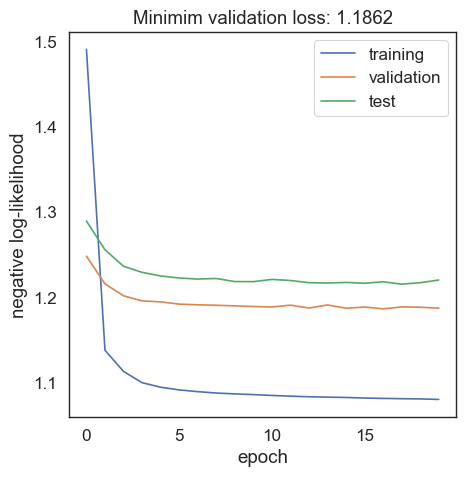

In [343]:
sns.set_theme(context='paper',style='white',font_scale=1.4)
# with sns.plotting_context("talk", rc={"lines.linewidth": 2}):
plt.figure(figsize=(5,5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(test_losses)
plt.legend(["training","validation","test"])
plt.xlabel('epoch')
plt.ylabel('negative log-likelihood')
plt.title(f"Minimim validation loss: {min(val_losses):.4f}")
plt.show()

In [297]:
PATH = '../../PhD/data/pickle/df_map1.pkl'
test_map = pd.read_pickle(PATH)

data['X_map'] = (test_map[predictors].to_numpy() - x_mean) / x_std

model.eval()

with torch.no_grad():
    map_inputs = torch.Tensor(data['X_map'][:,:d])
    map_outputs = model(map_inputs)

In [299]:
%%time
map_results = build_results_df(test_map,
                       outputs=map_outputs,
                       st_names_test=None,
                       model=model,
                       p=0.05,
                       confidence_intervals=True)

CPU times: user 2.5 s, sys: 26.4 ms, total: 2.53 s
Wall time: 2.52 s


In [29]:
# from scipy.interpolate import griddata

# xRange = np.sort(map_results['X'].unique())
# yRange = np.sort(map_results['Y'].unique())
# points = list(zip(map_results.X,map_results.Y))
# values = map_results['wrf_prcp'].values

# #create arrays of x,y over the raster extension
# gridX,gridY = np.meshgrid(xRange,yRange)

# #interpolate over the grid
# gridValues = griddata(points, values, (gridX,gridY), method='linear')

# #show interpolated values
# plt.imshow(gridValues)
# plt.gca().invert_yaxis()
# plt.xticks([]), plt.yticks([])
# plt.show()

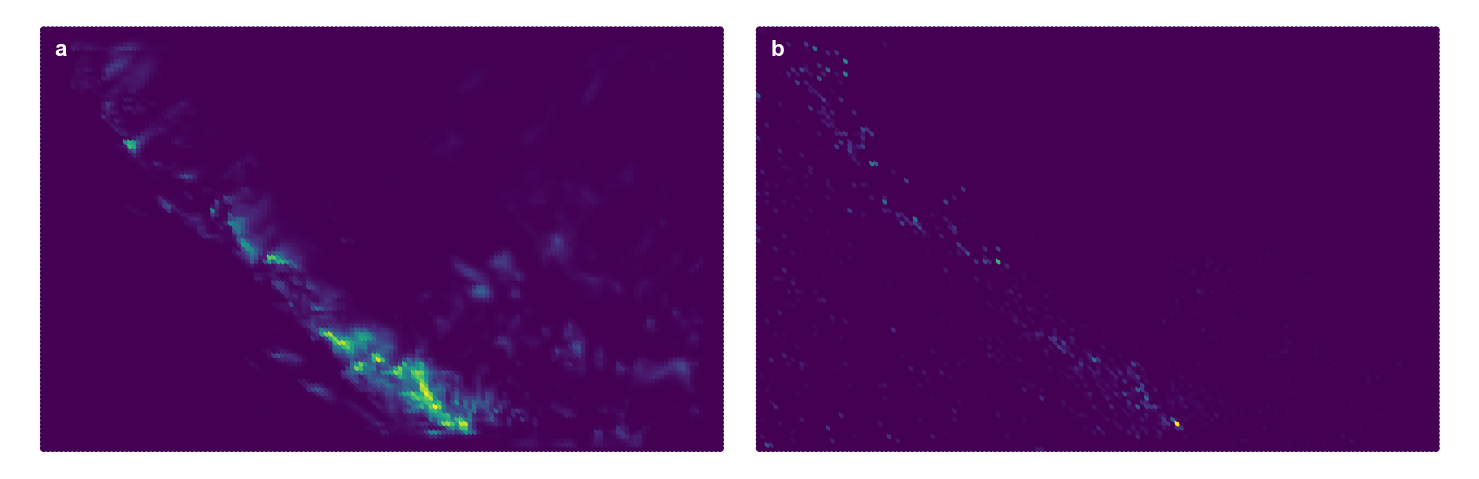

In [332]:
n = 2
fig, axes = plt.subplots(1,n,figsize=(n*5 + 5, 5))
cols = ['wrf_prcp','sample_0','high_ci','low_ci','Z']
labels = ['WRF', 'Samples']
a = ['a','b']

map_results = build_results_df(test_map,
                           outputs=map_outputs,
                           st_names_test=None,
                           model=model,
                           p=0.05,
                           confidence_intervals=True,
                           )

for index, ax in enumerate(axes.flatten()):
    
    if index < len(cols):
        col = cols[index]
    else:
        col = cols[-1]
    
    ax.scatter(x=map_results['X'], y=map_results['Y'], c=map_results[col], cmap="viridis")
    #ax.set_title(labels[index], fontsize=16)
    ax.set_xticklabels([]), ax.set_yticklabels([])
    ax.set_frame_on(False)
    ax.set_xticks([]), ax.set_yticks([])
    #ax.set_frame_on(True)
    
    ax.text(0.06, 0.90, f'{a[index]}', fontweight="bold", transform=ax.transAxes, size='large', color='white')#bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
plt.tight_layout(w_pad=-1.5)
plt.savefig('figures/sampled_map', dpi=300)
plt.show()

In [745]:
model.eval()

with torch.no_grad():
    
    test_inputs = test_dataset.tensors[0]
    test_outputs = model(test_inputs)

#     test2_inputs = test2_dataset.tensors[0]
#     test2_outputs = model(test2_inputs)

In [256]:
def sample_mc(model, theta_dict):
    if model.likelihood == 'bgmm':
        pi = theta_dict['pi']
        alpha = theta_dict['alpha']
        beta = theta_dict['beta']
        
        perc = np.random.uniform(0,1)
        
        if perc > pi:
            quantile = (perc-pi)/(1-pi)
            return stats.gamma.ppf(quantile, a=alpha, loc=0, scale=1/beta)
        else:
            return 0

In [257]:
def truncate_sample(x, threshold):
    if x<threshold:
        return x
    else:
        return threshold

In [347]:
model.eval()

with torch.no_grad():
    for index in range(len(test_dataset.tensors[0])):
        if index==0:
            a = torch.tensor(0)
        else:
            a = torch.tensor(norm_sample)
            
        test_inputs = torch.cat([test_dataset.tensors[0][index,:-1],a.unsqueeze(0)])
        
        test_outputs = model(test_inputs.unsqueeze(0).float())
        
        theta_params = ['pi','alpha','beta']
        
        theta_dict = {key:test_outputs[0,i] for i, key in enumerate(theta_params)}
        
        sample = sample_mc(model, theta_dict)
        
#         sample = truncate_sample(sample, threshold=350)
        
        norm_sample = (sample - x_mean[-1])/x_std[-1]
        
        if index==0:
            bs = torch.cat([test_outputs.squeeze(),torch.tensor(sample).unsqueeze(0)]).unsqueeze(0)
        else:
            b = torch.cat([test_outputs.squeeze(),torch.tensor(sample).unsqueeze(0)]).unsqueeze(0)
            bs = torch.cat([bs,b],dim=0)
        
        print(index) if index%10000==0 else None

0
10000


### Histograms of predicted parameter values 

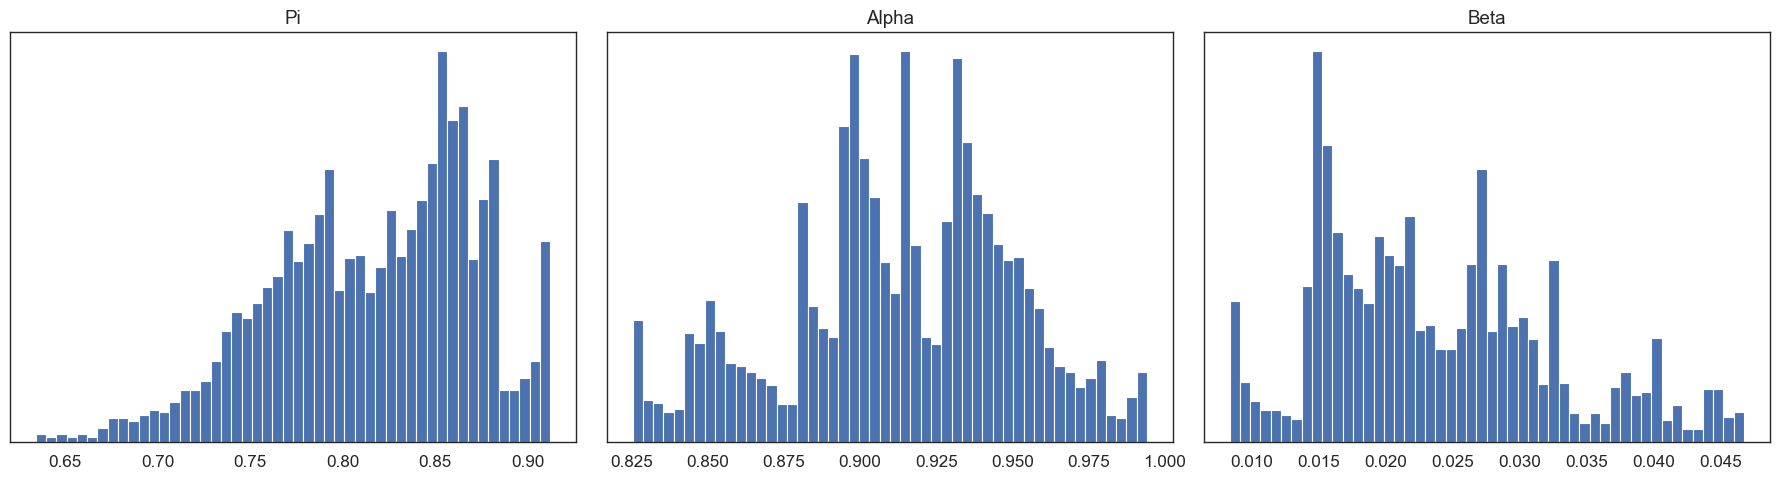

In [775]:
sns.set_theme(context='paper',style='white',font_scale=1.4)
plot_parameter_histograms(model, test_outputs)
plt.tight_layout()
plt.savefig('figures/parameter_histograms.png',dpi=300)
plt.show()

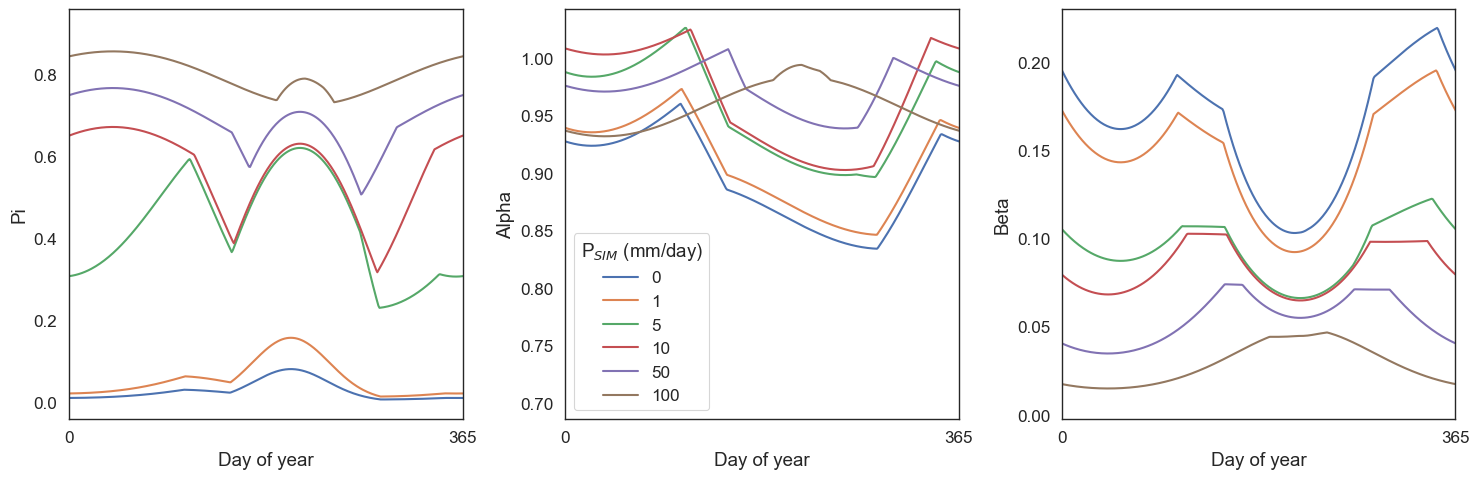

In [768]:
# %%capture

sns.set_theme(context='paper',style='white',font_scale=1.4)

title_labels = ['pi', 'alpha', 'beta'] 

fig, axes = plt.subplots(1,3, figsize=(15,5))

for idx, ax in enumerate(axes.flatten()):
    for i in [0,1,5,10,50,100]:
        zero_wrf = test_dataset.tensors[0][:,0].mode()[0] 
        test_inputs = test_dataset.tensors[0].clone()
        test_inputs[:,0:1] = zero_wrf + (i-x_mean[0])/x_std[0]
        model.eval()
        with torch.no_grad():
            test_outputs = model(test_inputs)
        if idx==0:
            ax.plot(1-test_outputs[:,idx], label=i, linewidth=1.5)
        else:
            ax.plot(test_outputs[:,idx], label=i, linewidth=1.5)
    if idx==1:
        ax.legend(title="P$_{SIM}$ (mm/day)", loc="lower left")
    ax.set_xlim(0,365)
    ax.set_xticks([0,365])
    #ax.set_title(title_labels[idx])
    ax.set_xlabel("Day of year")
    ax.set_ylabel(title_labels[idx].capitalize())
        
plt.tight_layout()
plt.savefig('figures/parameter_timeseries.png',dpi=300)
plt.show()

In [1291]:
def plot_bgmm_params_annual_timeseries(st_test, station='Pandoh', start_time='2003-01-01', end_time='2003-12-31'):

    """ Creates a figure with 3 subplots plotting annual evolution of the BGMM parameters"""

    df = st_test[st_test['Station']==station]
    df = clip_time_period(df, start_time, end_time)

    fig,[ax1,ax2] = plt.subplots(2,1,figsize=(15,10))
    ax1.plot(df['pi'],label='pi')
    ax1.plot(df['alpha'],label='alpha')
    ax1.plot(df['beta'],label='beta')
    ax1.legend()
    ax2.plot(df['wrf_prcp'],label='wrf')
    ax2.plot(df['Prec'],label='obs')
    ax2.legend()
    plt.tight_layout()
    plt.show()

In [965]:
%%capture

# sns.set_theme()
# list_of_stations = ['Berthin','Daslehra']
# # fig, axes = plt.subplots(1,2,figsize=(10,5))
# # for idx, ax in enumerate(axes.flatten()):
# #     s = list_of_stations[idx]
# #     df = st_test[st_test['Station']==s]
# #     y = df['sample']-df['Prec']
# #     ax.scatter(x=df['Prec'],y=y,label=s)
# #     ax.legend()

# df = clip_time_period(st_test,'2000-01-01','2005-01-31')
# df = df[df['Station'].isin(list_of_stations)]
# df['residuals'] = df['sample'] - df['Prec']
# #df.groupby(['Station'])['wrf_prcp'].first().unstack()#.unstack()
# df = df.pivot(index='Date',
#         columns='Station',
#         values='residuals')

# df.dropna(inplace=True)
# # df1 = df[df['Station']=='Sainj']
# # y1 = df1['wrf_prcp']-df1['Prec']
# # df2 = df[df['Station']=='Larji']
# # y2 = df2['wrf_prcp']-df2['Prec']
# plt.scatter(df[list_of_stations[0]],df[list_of_stations[1]])
# plt.show()

# np.corrcoef(df[list_of_stations[0]],df[list_of_stations[1]])

### Plot sample distribution

In [966]:
# plot_sample_distribution(model, outputs, test_dataset, force_non_zero=True)

### Summary of results

In [357]:
n_samples = 1

In [29]:
# st_test = st[(st['Year'].isin(years_dict['test']))]
# st_test[['pi','alpha','beta','sample_0']] = bs.numpy()

In [268]:
st_names_dict['test']

['Jogindernagar', 'Pandoh', 'Suni', 'Sundernagar', 'Ghumarwin', 'Nadaun']

In [358]:
%%time

if split_by == 'year':
    input_df = st[(st['Year'].isin(years_dict['test']))].copy()
    input_st_names = None 
elif split_by == 'station':
    input_df = st.copy()
    input_st_names = st_names_dict['test']
    

st_test = build_results_df(df=input_df,
                           outputs=bs[:,:3],#test_outputs,
                           st_names_test=input_st_names, #st_names_dict['test'],
                           model=model,
                           p=0.05,
                           confidence_intervals=True,
                           draw_samples=True,
                           n_samples=n_samples)

CPU times: user 5.11 s, sys: 49.1 ms, total: 5.16 s
Wall time: 5.15 s


In [361]:
st_test['sample_0'] = bs[:,-1]

In [34]:
st_test = st_test[st_test['Station'].isin(st_names)].copy() if split_by == 'year' else st_test

In [166]:
# %%time
# st_test = build_results_df(st,
#                            outputs=test_outputs,
#                            st_names_test=st_names_dict['test'],
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True,
#                            calculate_errors=True,
#                            n_samples=3)

In [167]:
# list_wet_days_mlp = []

# for i in range(10):
    
#     df = build_results_df(st,
#                            outputs=test_outputs,
#                            st_names_test=st_names_dict['test'],
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True)

#     wet_days_mlp = (df['sample']!=0).sum()
#     # print(i, wet_days_mlp)

#     list_wet_days_mlp.append(wet_days_mlp)
    
# wet_days_reg = (df['wrf_bc_prcp']!=0).sum()
# wet_days_obs = (df['Prec']!=0).sum()

In [168]:
# plt.plot(list_wet_days_mlp,'o')
# plt.plot([0,9],[np.mean(list_wet_days_mlp),np.mean(list_wet_days_mlp)])
# plt.plot([wet_days_obs]*10)
# plt.plot([wet_days_reg]*10)
# plt.show()

In [169]:
# np.mean(list_wet_days_mlp/wet_days_obs) , np.std(list_wet_days_mlp/wet_days_obs)

# print(f"Ratio of predicted vs actual wet days (BC): {wet_days_reg / wet_days_obs:.4f}")
# print(f"Ratio of predicted vs actual wet days (MLP): {np.mean(list_wet_days_mlp/wet_days_obs):.4f}")

In [170]:
# st_test = build_results_df(st_val,
#                            outputs=test2_outputs,
#                            st_names_test=st_val['Station'].unique(),
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True)

In [365]:
st_test = predictions['$B2GMM_{[100]}$']['k_all'].copy()

In [324]:
# st_test = st_test[st_test['Station'].isin(st_names)].copy()
st_test['sample_0'].sort_values(ascending=False).head(5)

198365    408.811613
180648    337.227670
97403     328.276531
220463    294.968843
10121     268.434375
Name: sample_0, dtype: float64

In [344]:
%%capture
almost_dry = 0
n_samples= 10

print(f"Ratio of predicted vs actual wet days (BC): {(st_test['wrf_bc_prcp']>almost_dry).sum() / (st_test['Prec']>almost_dry).sum():.4f}")

for i in range(n_samples):
    print(f"Ratio of predicted vs actual wet days (MLP) {i}: {(st_test[f'sample_{i}']>almost_dry).sum() / (st_test['Prec']>almost_dry).sum():.4f}")

for i in range(n_samples):
    tail_high = (st_test[f'sample_{i}']>st_test['high_ci']).sum()
    tail_low = (st_test[f'sample_{i}']<st_test['low_ci']).sum()

    print(f"Percentage of high outliers at 95% confidence: {(tail_high) / len(st_test):.4f}")
    print(f"Percentage of low outliers at 95% confidence: {(tail_low) / len(st_test):.4f}")

In [347]:
ci_dict = {}
dd_dict = {}
for s in st_test['Station'].unique():
    ci_dict[s] = []
    dd_dict[s] = []
    st_test_s = st_test[st_test["Station"]==s]
    for i in range(n_samples):
        tail_high = (st_test_s[f'sample_{i}']>st_test_s['high_ci']).sum()
        tail_low = (st_test_s[f'sample_{i}']<st_test_s['low_ci']).sum()
        ci_dict[s].append((tail_high + tail_low) / len(st_test_s))
        dd_dict[s].append((st_test_s[f'sample_{i}']>almost_dry).sum() / (st_test_s['Prec']>almost_dry).sum())

ci_means = []
dd_means = []
for k,v in ci_dict.items():
    ci_means.append(np.mean(v))
    #print(f'{k}: {np.mean(v):.4f}')
print(f'CI: {np.mean(ci_means)}')

for k,v in dd_dict.items():
    dd_means.append(np.mean(v))
    #print(f'{k}: {np.mean(v):.4f}')
print(f'DD: {np.mean(dd_means)}') 

CI: 0.03955895430880332
DD: 1.0970144843822787


In [349]:
def truncate_sample(x, threshold=300):
    if x>threshold:
        return threshold
    else:
        return x

In [350]:
# st_test_nontruncated = st_test.copy()
    
# for i in range(n_samples):
#     st_test[f'sample_{i}'] = st_test[f'sample_{i}'].apply(lambda x: truncate_sample(x))

In [329]:
st_test = pairwise_errors(st_test)
pairwise_mse = st_test.groupby(['Station']).mean()[['se_wrf','se_bcp']+[f'se_mlp_sample_{i}' for i in range(n_samples)]].reset_index()
pairwise_mse.mean()

se_wrf             177.101058
se_bcp             181.154971
se_mlp_sample_0    200.989262
se_mlp_sample_1    196.966661
se_mlp_sample_2    195.844953
se_mlp_sample_3    197.917888
se_mlp_sample_4    204.531151
se_mlp_sample_5    200.887831
se_mlp_sample_6    195.667483
se_mlp_sample_7    197.826853
se_mlp_sample_8    197.934131
se_mlp_sample_9    198.468323
dtype: float64

In [76]:
n_samples = 10

### Plot squared errors

In [77]:
sample_cols = [f'sample_{i}' for i in range(n_samples)]
add_cols = []

columns = ['Prec','wrf_prcp','wrf_bc_prcp'] + sample_cols + add_cols
labels = ['Obs', 'WRF', 'Bias corrected WRF','Sample (MLP)']
seasons = st_test['season'].unique()
basins = st_test['Basin'].unique()

In [78]:
#st_test['sample']=st_test['sample_1'].astype('float64').copy()

In [79]:
len(st_test['Station'].unique())

3

## Seasonal predictions

In [406]:
# st_test = st_test[st_test['median']>200]

### Analsys of results (per season per year)

In [374]:
def count_zeros(x,threshold=0):
    return np.sum(x<=threshold)

In [375]:
def SMAPE(df, sim, obs):
    if abs(df[sim] - df[obs]) == 0:
        return 0
    else:
        return abs(df[sim] - df[obs]) / (df[sim] + df[obs])

In [409]:
df_annual = st_test.groupby(['Station','Year','Basin']).sum()[columns].copy()
df_annual['sample'] = df_annual[sample_cols].mean(axis=1)

df_annual['se_wrf'] = (df_annual['wrf_prcp'] - df_annual['Prec'])**2
df_annual['se_wrf_bc'] = (df_annual['wrf_bc_prcp'] - df_annual['Prec'])**2

for i in range(n_samples):
    df_annual[f'se_mlp_{i}'] = (df_annual[f'sample_{i}'] - df_annual['Prec'])**2
df_annual['se_mlp'] = df_annual[[f'se_mlp_{i}' for i in range(n_samples)]].mean(axis=1)

# Totals
annual_totals = df_annual.reset_index().melt(id_vars=['Station','Year','Basin'],
                      value_vars=['Prec','wrf_prcp','wrf_bc_prcp','sample'] + add_cols
                     )   

annual_se = df_annual.reset_index().melt(id_vars=['Station','Year','Basin'],
                      value_vars=['se_wrf','se_wrf_bc','se_mlp']
                     )  

rmse = np.sqrt(annual_se.groupby(['Basin','variable']).mean())

In [185]:
def add_to_dict(xs,d):
    for x in xs:
        print(x)
        key = f'{x=}'.split('=')[0]
        d[key] = x
    return d

def seasonal_analysis(st_test):

    df = st_test.groupby(['Station','season','Year']).sum()[columns].copy()

    df_dry_days = st_test.groupby(['Station','season','Year'], as_index=False)[columns]
    df_dry_days = df_dry_days.agg([count_zeros]).droplevel(level=1, axis=1)

    # NUMBER OF DRY DAYS - ABSOLUTE ERROR 
    for i in range(n_samples):
        df_dry_days[f'edd_mlp_{i}'] = (df_dry_days[f'sample_{i}'] - df_dry_days['Prec'])

    df_dry_days['edd_mlp'] = abs(df_dry_days[[f'edd_mlp_{i}' for i in range(n_samples)]].mean(axis=1))
    df_dry_days['edd_wrf_prcp'] = abs(df_dry_days['wrf_prcp'] - df_dry_days['Prec'])
    df_dry_days['edd_wrf_bc_prcp'] = abs(df_dry_days['wrf_bc_prcp'] - df_dry_days['Prec'])

    df_dry_days = df_dry_days[['edd_wrf_prcp','edd_wrf_bc_prcp','edd_mlp']]

    # PRECIPITATION - SQUARED ERROR 
    df['se_wrf_prcp'] = (df['wrf_prcp'] - df['Prec'])**2
    df['se_wrf_bc_prcp'] = (df['wrf_bc_prcp'] - df['Prec'])**2

    df['sample'] = df[sample_cols].mean(axis=1)

    for i in range(n_samples):
        df[f'se_mlp_{i}'] = (df[f'sample_{i}'] - df['Prec'])**2


    df['se_mlp'] = df[[f'se_mlp_{i}' for i in range(n_samples)]].mean(axis=1)

    # PRECIPITATION - ERROR & ABSOLUTE ERROR
    df['e_wrf_prcp'] = (df['wrf_prcp'] - df['Prec'])
    df['e_wrf_bc_prcp'] = (df['wrf_bc_prcp'] - df['Prec'])  

    df['ae_wrf_prcp'] = abs(df['wrf_prcp'] - df['Prec'])
    df['ae_wrf_bc_prcp'] = abs(df['wrf_bc_prcp'] - df['Prec'])

    for i in range(n_samples):
        df[f'e_mlp_{i}'] = (df[f'sample_{i}'] - df['Prec'])
        df[f'ae_mlp_{i}'] = abs(df[f'sample_{i}'] - df['Prec'])

    df['e_mlp'] = df[[f'e_mlp_{i}' for i in range(n_samples)]].mean(axis=1)    
    df['ae_mlp'] = df[[f'ae_mlp_{i}' for i in range(n_samples)]].mean(axis=1)

    # PRECIPITATION - ABSOLUTE ERROR REDUCTION
    df['aer_mlp'] = df['ae_wrf_prcp'] - df['ae_mlp']
    df['aer_wrf_bc_prcp'] = df['ae_wrf_prcp'] - df['ae_wrf_bc_prcp']

    # PRECIPITATION - MSE IMPROVEMENT RATIO
    df['imp_wrf_bc_prcp'] = 1 - df['se_wrf_bc_prcp']/(df['se_wrf_prcp'])
    df['imp_mlp'] = 1 - df['se_mlp']/(df['se_wrf_prcp'])

    # PRECIPITATION - SMAPE
    df['smape_wrf_prcp'] = df.apply(SMAPE, axis=1, args=('wrf_prcp','Prec')) 
    df['smape_wrf_bc_prcp'] = df.apply(SMAPE, axis=1, args=('wrf_bc_prcp','Prec')) 
    df['smape_mlp'] = df.apply(SMAPE, axis=1, args=('sample','Prec')) 

    if 'mean' in add_cols:
        df['smape_mlp_mean'] = df.apply(SMAPE, axis=1, args=('mean','Prec'))  
    if 'median' in add_cols:
        df['smape_mlp_median'] = df.apply(SMAPE, axis=1, args=('median','Prec')) 

    df = pd.merge(df,df_dry_days,on=['Station','season','Year'])

    return df

def seasonal_summaries(st_test):

    # Totals
    totals = df.reset_index().melt(id_vars=['Station','season','Year'],
                          value_vars=['Prec','wrf_prcp','wrf_bc_prcp','sample'] + add_cols
                         )
    
    # Error
    e = df.reset_index().melt(id_vars=['Station','season','Year'],
                          value_vars=['e_wrf_prcp','e_wrf_bc_prcp','e_mlp']#,'imp_bc_wrf','imp_mlp','se_wrf','se_bc_wrf','se_mlp','edd_mlp','edd_bc'],
                         )

    # MAE
    ae = df.reset_index().melt(id_vars=['Station','season','Year'],
                          value_vars=['ae_wrf_prcp','ae_wrf_bc_prcp','ae_mlp']#,'imp_bc_wrf','imp_mlp','se_wrf','se_bc_wrf','se_mlp','edd_mlp','edd_bc'],
                         )
    
    # SE
    se = df.reset_index().melt(id_vars=['Station','season','Year'],
                          value_vars=['se_wrf_prcp','se_wrf_bc_prcp','se_mlp']#,'imp_bc_wrf','imp_mlp','se_wrf','se_bc_wrf','se_mlp','edd_mlp','edd_bc'],
                         )

    # MAE REDUCTION
    aer = df.reset_index().melt(id_vars=['Station','season','Year'],
                          value_vars=['aer_wrf_bc_prcp','aer_mlp'],
                         )
    # ERROR IN DRY DAYS 
    edd = df.reset_index().melt(id_vars=['Station','season','Year'],
                          value_vars=['edd_wrf_prcp','edd_wrf_bc_prcp','edd_mlp'],
                         )

    # MSE IMPROVEMENT RATIO                    
    improvement = df.reset_index().melt(id_vars=['Station','season','Year'],
                          value_vars=['imp_wrf_bc_prcp','imp_mlp'],
                         )
    # SMAPE
    smape = df.reset_index().melt(id_vars=['Station','season','Year'],
                          value_vars=['smape_wrf_prcp','smape_wrf_bc_prcp','smape_mlp'] + [f'smape_mlp_{i}' for i in add_cols]
                     )
        
    d = {}
    
    d['totals'] = totals
    d['e'] = e
    d['ae'] = ae
    d['se'] = se
    d['aer'] = aer
    d['edd'] = edd
    d['improvement'] = improvement
    d['smape'] = smape
    
    return d
    
    return d

In [376]:
%%time 
df = seasonal_analysis(st_test)
seasonal_dict = seasonal_summaries(df)

CPU times: user 2.93 s, sys: 17.3 ms, total: 2.94 s
Wall time: 2.95 s


In [412]:
df_multiyear = df.groupby(['Station','season']).mean()[columns + ['sample']].reset_index()
df_annual_multiyear = df_annual.groupby(['Station']).mean()[columns + ['sample']].reset_index()

table = []
sample_flag = 0 # 'all' or 0, 1, 2,...
sample_name = 'sample' if sample_flag == 'all' else f'sample_{sample_flag}'

for season in seasons:
    
    dfp = df_multiyear[df_multiyear['season']==season]
    a = abs(dfp['wrf_prcp'] - dfp['Prec'])/(dfp['wrf_prcp'] + dfp['Prec'])
    b = abs(dfp['wrf_bc_prcp'] - dfp['Prec'])/(dfp['wrf_bc_prcp'] + dfp['Prec'])
    c = abs(dfp[sample_name] - dfp['Prec'])/(dfp[sample_name] + dfp['Prec'])
    d = abs(dfp['sample'] - dfp['Prec'])/(dfp['sample'] + dfp['Prec'])
    row = [f'{season}', f'{a.mean():.2f}', f'{b.mean():.2f}', f'{c.mean():.2f}', f'{d.mean():.2f}', f'{a.median():.2f}', f'{b.median():.2f}', f'{c.median():.2f}', f'{d.median():.2f}']
    table.append(row)

dfp = df_annual_multiyear
a = abs(dfp['wrf_prcp'] - dfp['Prec'])/(dfp['wrf_prcp'] + dfp['Prec'])
b = abs(dfp['wrf_bc_prcp'] - dfp['Prec'])/(dfp['wrf_bc_prcp'] + dfp['Prec'])
c = abs(dfp[sample_name] - dfp['Prec'])/(dfp[sample_name] + dfp['Prec'])
d = abs(dfp['sample'] - dfp['Prec'])/(dfp['sample'] + dfp['Prec'])
row = ['All year', f'{a.mean():.2f}', f'{b.mean():.2f}', f'{c.mean():.2f}', f'{d.mean():.2f}', f'{a.median():.2f}', f'{b.median():.2f}', f'{c.median():.2f}', f'{d.median():.2f}']
table.append(row)

headers = ['Season', 'Mean WRF', 'Mean CANLR', 'Mean MLP', 'Mean MLP (k=10)', 
                     'Median WRF', 'Median CANLR', 'Median MLP', 'Median MLP (k=10)']

print(tabulate(table, headers, tablefmt='simple'))

Season               Mean WRF    Mean CANLR    Mean MLP    Mean MLP (k=10)    Median WRF    Median CANLR    Median MLP    Median MLP (k=10)
-----------------  ----------  ------------  ----------  -----------------  ------------  --------------  ------------  -------------------
Winter (JFM)             0.2           0.13        0.15               0.13          0.13            0.06          0.08                 0.06
Premonsoon (AM)          0.41          0.15        0.12               0.12          0.42            0.1           0.08                 0.08
Monsoon (JJAS)           0.16          0.1         0.12               0.12          0.14            0.08          0.09                 0.1
Postmonsoon (OND)        0.23          0.15        0.19               0.15          0.2             0.11          0.15                 0.11
All year                 0.17          0.12        0.08               0.08          0.14            0.07          0.06                 0.06


In [413]:
# sns.histplot(data=e[e['variable']=='e_mlp'], x='value')
# plt.show()

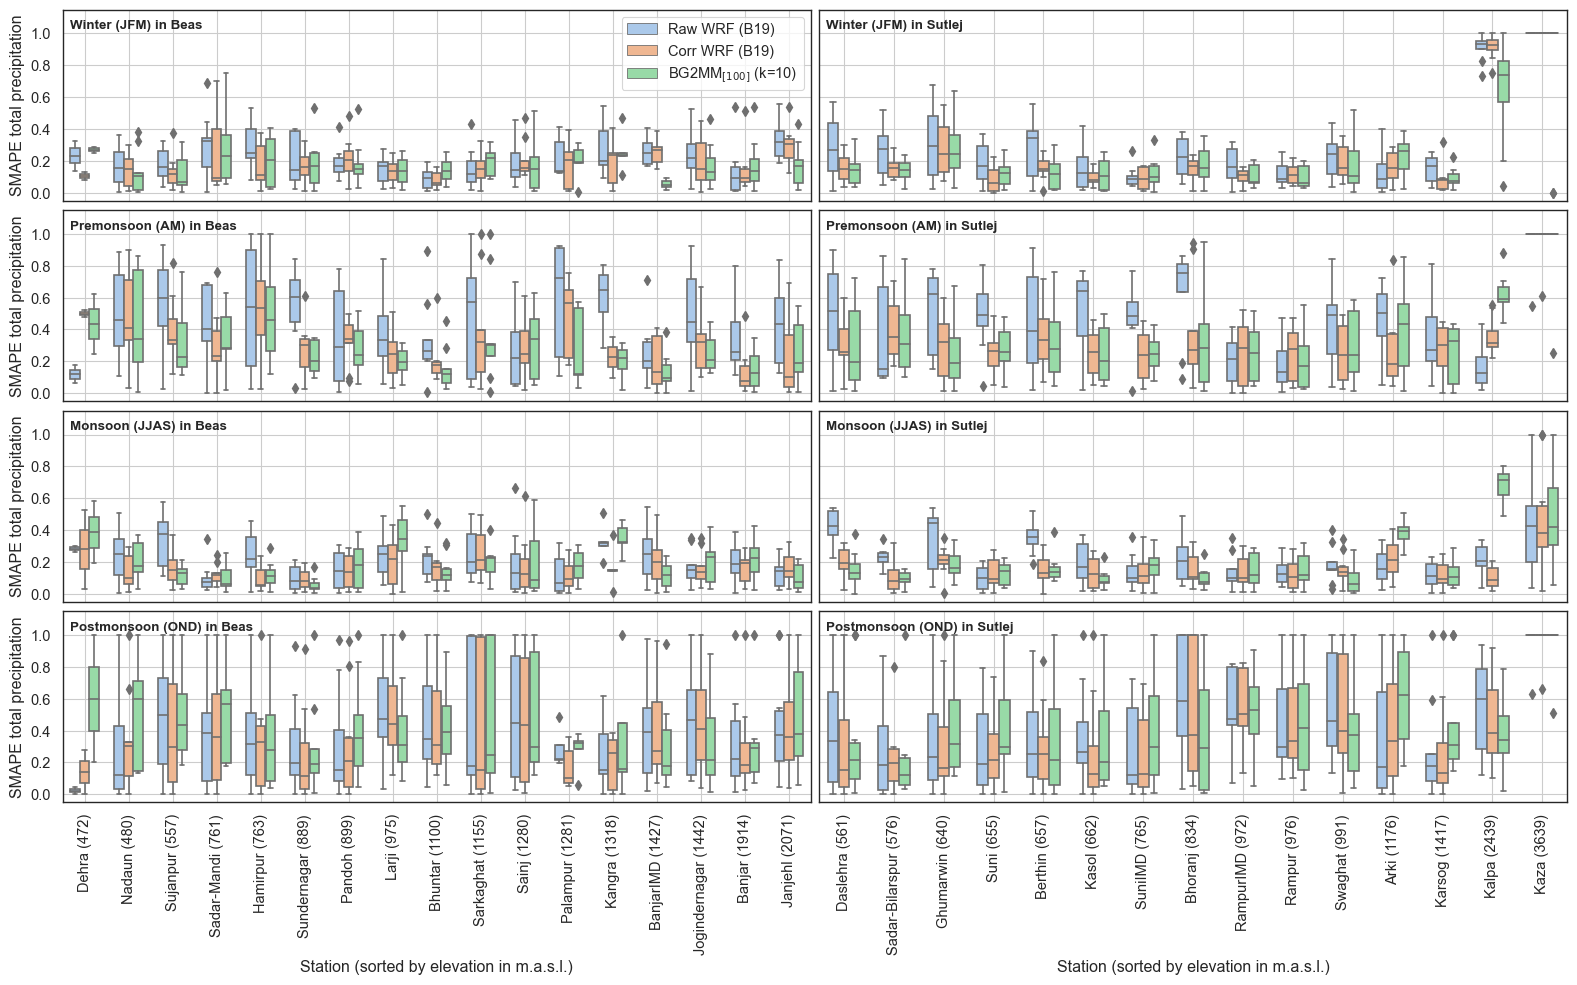

In [373]:
data1 = seasonal_dict['smape'].copy()

sns.set_theme(context='paper',style='white',font_scale=1.2)

new_labels = ['Raw WRF (B19)', 'Corr WRF (B19)','BG2MM$_{[100]}$ (k=10)']
#new_labels = ['Bias-corrected WRF (Bannister et al., 2019)','Bias-correted WRF (MLP)']
# yaxislabel = 'Error reduction (mm)'
yaxislabel = 'SMAPE total precipitation'

fig, axes = plt.subplots(4,len(basins),figsize=(16,10))

for i, season in enumerate(seasons):
    
    data2 = data1[data1['season']==season].copy()
    
    for j, basin in enumerate(basins):
        
        ax = axes[i, j] if not(filter_by_basin_flag) else axes[i]

        st_basin = st_test[st_test['Basin']==basin]

        sorted_stations = st_basin.groupby(['Station']).mean().sort_values('Z').reset_index()['Station'].unique()
        sorted_elevations = [int(a) for a in st_basin.groupby(['Station']).mean().sort_values('Z').reset_index()['Z'].unique()]

        sorted_labels = [f'{b} ({a})' for a,b in zip(sorted_elevations,sorted_stations)]

        data3 = data2[data2['Station'].isin(sorted_stations)].copy()
#         data3['value'] = abs(data3['value']).copy()

        sns.boxplot(data=data3, x='Station',y='value',hue='variable', ax=ax, order=sorted_stations, width=0.65, palette='pastel')
        ax.set_ylim(-0.05,1.15)
        ax.grid()
        
        if i == 0:
            pass #ax.set_title(basin)
        if i == 3:
            ax.set_xlabel('Station (sorted by elevation in m.a.s.l.)')
            ax.set_xticklabels(sorted_labels,rotation=90, horizontalalignment='center')
        else:
            ax.set_xlabel(None)
            ax.set_xticklabels([])
            
        if j == 0:
            ax.set_ylabel(yaxislabel)
            pass #ax.set_ylabel(f'{season}')
        else:
            ax.set_yticklabels([])
            ax.set_ylabel(None)
        
        ax.text(0.01, 0.9, f'{season} in {basin}', fontweight="bold", transform=ax.transAxes, size='small')
        
        # ax.set_ylim(-400,400)
        # plt.ylabel('Correlation factor')
        # plt.xlabel('Lag (days)')
        
        if (i == j == 0):
            ax.legend(loc='best')
            leg = ax.get_legend()
            leg.set_title('')
            for t, l in zip(leg.texts, new_labels): t.set_text(l)
        else:
            ax.get_legend().remove()

plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig('figures/seasonal-boxplot-smape.png',dpi=300)
plt.show()

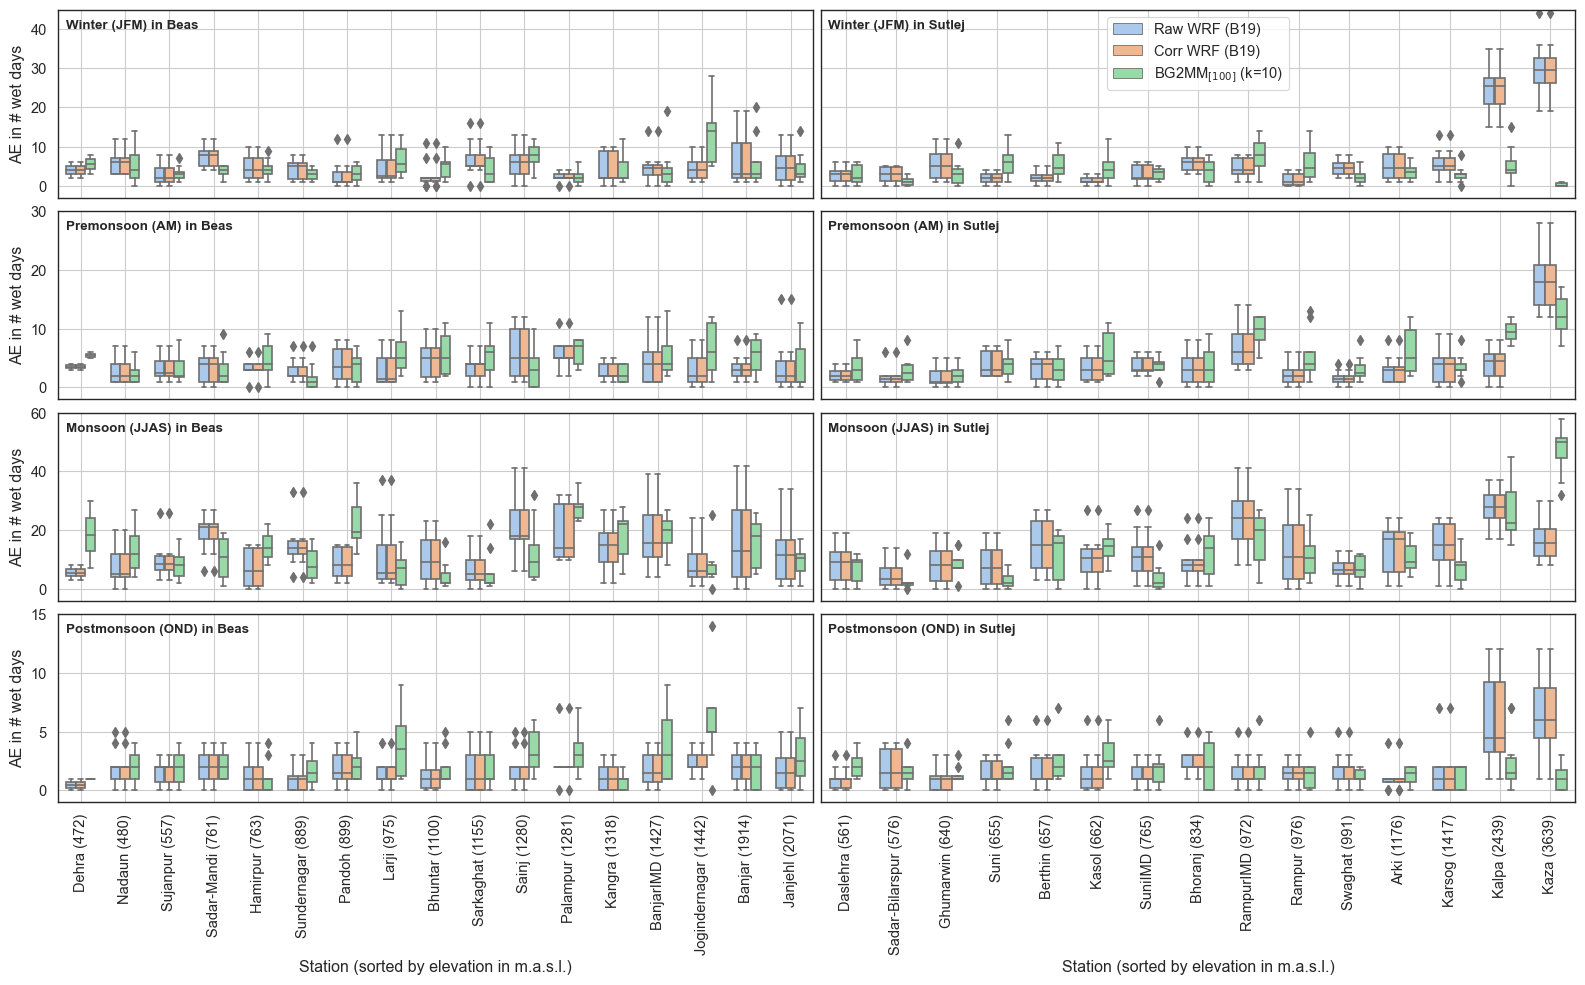

In [385]:
data1 = seasonal_dict['edd'].copy()

sns.set_theme(context='paper',style='white',font_scale=1.2)

new_labels = ['Raw WRF (B19)', 'Corr WRF (B19)','BG2MM$_{[100]}$ (k=10)']
#new_labels = ['Bias-corrected WRF (Bannister et al., 2019)','Bias-correted WRF (MLP)']
# yaxislabel = 'Error reduction (mm)'
yaxislabel = 'AE in # wet days'

fig, axes = plt.subplots(4,len(basins),figsize=(16,10))

for i, season in enumerate(seasons):
    
    data2 = data1[data1['season']==season].copy()
    
    for j, basin in enumerate(basins):
        
        ax = axes[i, j] if not(filter_by_basin_flag) else axes[i]

        st_basin = st_test[st_test['Basin']==basin]

        sorted_stations = st_basin.groupby(['Station']).mean().sort_values('Z').reset_index()['Station'].unique()
        sorted_elevations = [int(a) for a in st_basin.groupby(['Station']).mean().sort_values('Z').reset_index()['Z'].unique()]

        sorted_labels = [f'{b} ({a})' for a,b in zip(sorted_elevations,sorted_stations)]

        data3 = data2[data2['Station'].isin(sorted_stations)].copy()
#         data3['value'] = abs(data3['value']).copy()

        sns.boxplot(data=data3, x='Station',y='value',hue='variable', ax=ax, order=sorted_stations, width=0.65, palette='pastel')
        #ax.set_ylim(-0.05,1.15)
        ax.grid()
        
        if i == 0:
            pass #ax.set_title(basin)
        if i == 3:
            ax.set_xlabel('Station (sorted by elevation in m.a.s.l.)')
            ax.set_xticklabels(sorted_labels,rotation=90, horizontalalignment='center')
        else:
            ax.set_xlabel(None)
            ax.set_xticklabels([])
            
        if j == 0:
            ax.set_ylabel(yaxislabel)
            pass #ax.set_ylabel(f'{season}')
        else:
            ax.set_yticklabels([])
            ax.set_ylabel(None)
            
        if i == 0: ax.set_ylim(-3, 45)
        elif i == 1: ax.set_ylim(-2, 30)
        elif i == 2: ax.set_ylim(-4, 60)
        elif i == 3: ax.set_ylim(-1, 15)
        
        ax.text(0.01, 0.9, f'{season} in {basin}', fontweight="bold", transform=ax.transAxes, size='small')
        
        # ax.set_ylim(-400,400)
        # plt.ylabel('Correlation factor')
        # plt.xlabel('Lag (days)')
        
        if (i +1 == j == 1):
            ax.legend(loc='upper center')
            leg = ax.get_legend()
            leg.set_title('')
            for t, l in zip(leg.texts, new_labels): t.set_text(l)
        else:
            ax.get_legend().remove()

plt.tight_layout(h_pad=0.5, w_pad=0.5)
plt.savefig('figures/seasonal-boxplot-wetdays.png',dpi=300)
plt.show()

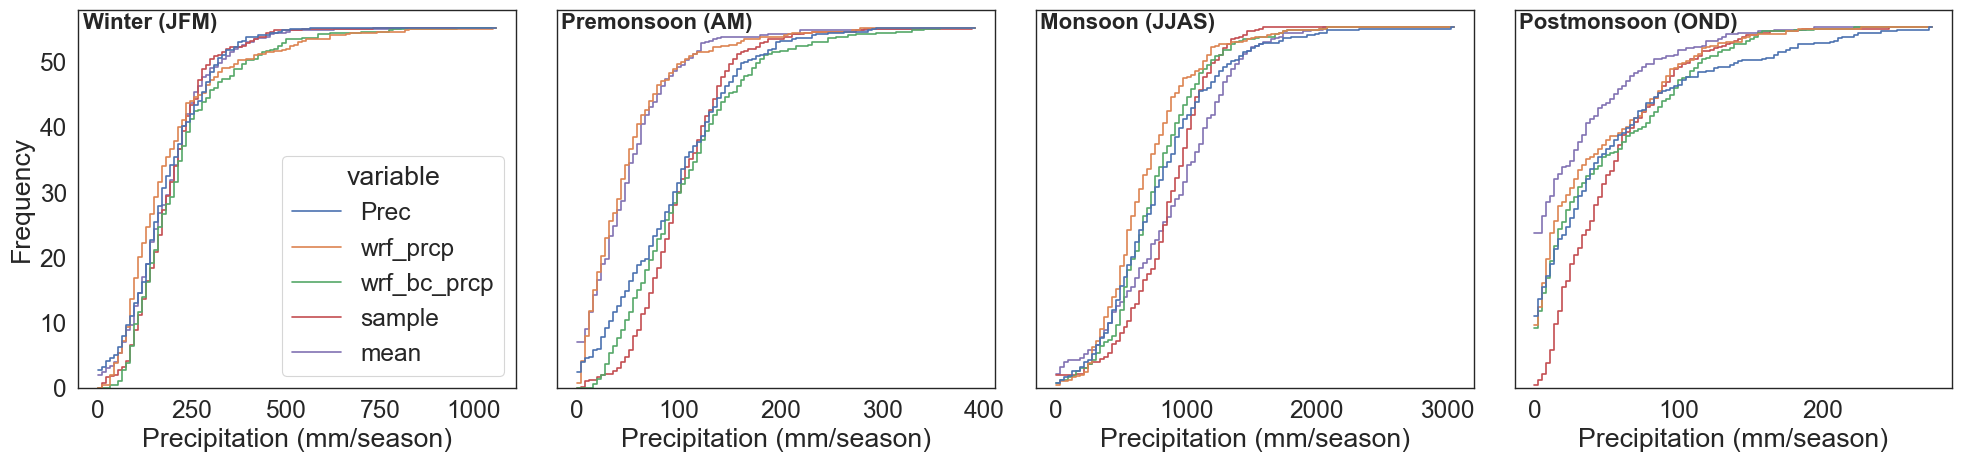

In [341]:
sns.set_theme(context='paper',style='white',font_scale=2)
plot_data = totals
fig, axes = plt.subplots(1,4,figsize=(20,5))
for index, ax in enumerate(axes.flatten()):
    season = seasons[index]
    sns.histplot(data=plot_data[plot_data['season']==season],x='value',hue='variable', 
                 bins=100, multiple='layer', element='step', stat='frequency',
                 cumulative=True, fill=False, shrink=0.8, ax=ax)
    ax.text(0.01, 0.95, f'{season}', fontweight="demibold", transform=ax.transAxes, size='small')
    ax.get_legend().remove() if index>0 else None
    ax.set_yticklabels([]) if index>0 else None
    ax.set_ylabel('') if index>0 else None
    ax.set_xlabel('Precipitation (mm/season)')
    
plt.tight_layout()
plt.show()

### Seasonal over the entire period

In [312]:
# st_test_season_totals = st_test.groupby(['Station','season']).sum()
# st_test_annual_totals = st_test.groupby(['Station']).sum()

In [313]:
# sns.set_theme(context='paper',style='white',font_scale=1.4)

# fig, axes = plt.subplots(5,1, figsize=(15,10))

# for i, ax in enumerate(axes.flatten()):

#     if i < 4: 

#         season = seasons[i]
#         df = st_test_season_totals[np.in1d(st_test_season_totals.index.get_level_values(1), [season])].copy()
#         df = df.reset_index().set_index('Station')

#     else: 
#         df = st_test_annual_totals
#         season = "Annual"

#     legend = True if i==0 else None
#     df[list(columns[l] for l in [0,1,2,3])].plot.bar(rot=45,ax=ax,legend=legend)

#     df['se_wrf'] = (df['wrf_prcp'] - df['Prec'])**2
#     df['se_bc_wrf'] = (df['wrf_bc_prcp'] - df['Prec'])**2
#     df['se_mlp'] = (df['sample'] - df['Prec'])**2

#     df['se_imp_bc_wrf'] = df['se_bc_wrf'] - df['se_wrf']
#     df['se_imp_mlp'] = df['se_mlp'] - df['se_wrf']
    
#     df['imp_bc_wrf'] = 1 - df['se_bc_wrf']/df['se_wrf']
#     df['imp_mlp'] = 1 - df['se_mlp']/df['se_wrf']

# #     ax.set_title("{0} \n\
# #                 MSE improvement ratio | median baseline : {1:.2f} | median NN : {2:.2f} | mean baseline : {3:.2f} | mean NN : {4:.2f} \n \
# #                 MSE improvement | median baseline : {5:.2f} | median NN : {6:.2f} | mean baseline : {7:.2f} | mean NN : {8:.2f} \n"
# #         .format(season,
# #                 df['imp_bc_wrf'].median(),
# #                 df['imp_mlp'].median(),
# #                 df['imp_bc_wrf'].mean(),
# #                 df['imp_mlp'].mean(),
# #                 df['se_imp_bc_wrf'].median(),
# #                 df['se_imp_mlp'].median(),
# #                 df['se_imp_bc_wrf'].mean(),
# #                 df['se_imp_mlp'].mean()
# #                )
# #         )

#     ax.set_title(f"{season}")

#     ax.set_xlabel(None)
#     ax.set_ylabel('Precipitation (mm)')
#     ax.set_xticklabels([]) if i < 4 else None

# plt.tight_layout()

### Seasonal totals 

In [987]:
# predictions_0 = preditions_2.copy()
# print(predictions_0.keys())
# predictions_0.update(preditions_4)
# print(predictions_0.keys())
# predictions_0.update(preditions_3)
# print(predictions_0.keys())
# predictions_0.update(preditions_1)
# print(predictions_0.keys())
# predictions_0.update(preditions_5)
# print(predictions_0.keys())

In [908]:
# for k in predictions.keys():
#     k.replace('_'," ")
#     print(k.replace('_'," ").replace('True','L').replace('False','NL').replace('gamma','$\Gamma$'))

In [193]:
metric = 'ae'
prefix = 'ae'

table = []

headers = ['Model']
row_a = ['Raw WRF']
row_b = ['WRF BC']

for index, (k,v) in enumerate(predictions.items()):
    
    df = seasonal_analysis(v['k_all'])
    d = seasonal_summaries(df)

    r = d[metric].copy()
    
    row = [f'{k}']
    
    for season in seasons:
        
        if index == 0: 
            headers.append(f'{season} mean')
            headers.append(f'{season} median')
        
        rs = r[r['season']==season].copy()
        
        if index==0:
            a = rs[rs['variable']==f'{prefix}_wrf_prcp']['value']
            b = rs[rs['variable']==f'{prefix}_wrf_bc_prcp']['value']
            row_a.append(f'{a.mean():.2f}')
            row_a.append(f'{a.median():.2f}')
            row_b.append(f'{b.mean():.2f}')
            row_b.append(f'{b.median():.2f}')
        
        c = rs[rs['variable']==f'{prefix}_mlp']['value']
        row.append(f'{c.mean():.2f}')
        row.append(f'{c.median():.2f}')
                
    if index==0:
        table.append(row_a)
        table.append(row_b)
        
    table.append(row)
    
    print(k)

$Gamma_{VGLM}$
$BGMM_{VGLM}$
$B2GMM_{VGLM}$
$Gamma_{[10]}$
$Gamma_{[30]}$
$Gamma_{[50]}$
$Gamma_{[100]}$
$Gamma_{[10, 10]}$
$Gamma_{[30, 30]}$
$Gamma_{[50, 50]}$
$Gamma_{[100, 100]}$
$BGMM_{[10]}$
$BGMM_{[30]}$
$BGMM_{[50]}$
$BGMM_{[100]}$
$BGMM_{[10, 10]}$
$BGMM_{[30, 30]}$
$BGMM_{[50, 50]}$
$BGMM_{[100, 100]}$
$B2GMM_{[10]}$
$B2GMM_{[30]}$
$B2GMM_{[50]}$
$B2GMM_{[100]}$
$B2GMM_{[10, 10]}$
$B2GMM_{[30, 30]}$
$B2GMM_{[50, 50]}$
$B2GMM_{[100, 100]}$


In [194]:
# table_smape = table.copy()
# table_edd = table.copy()
# table_edd_02 = table.copy()
table_ae = table.copy()

In [195]:
print(tabulate(table, headers, tablefmt='latex_raw', disable_numparse=True))

\begin{tabular}{lllllllll}
\hline
 Model                & Winter (JFM) mean   & Winter (JFM) median   & Premonsoon (AM) mean   & Premonsoon (AM) median   & Monsoon (JJAS) mean   & Monsoon (JJAS) median   & Postmonsoon (OND) mean   & Postmonsoon (OND) median   \\
\hline
 Raw WRF              & 96.46               & 58.98                 & 62.30                  & 46.67                    & 301.88                & 233.76                  & 29.24                    & 16.97                      \\
 WRF BC               & 87.53               & 49.49                 & 59.34                  & 48.59                    & 242.83                & 192.32                  & 26.89                    & 16.64                      \\
 $Gamma_{VGLM}$       & 285.14              & 99.31                 & 108.00                 & 98.99                    & 376645.34             & 786.43                  & 51.31                    & 36.70                      \\
 $BGMM_{VGLM}$        & 93.43              

In [893]:
# metric = 'smape'
# prefix = 'smape'

# for index, (k,v) in enumerate(predictions.items()):
    
#     df = seasonal_analysis(v['k_all'])
#     d = seasonal_summaries(df)
        
#     table = []
#     for season in seasons:
        
#         r = d[metric].copy()
        
#         rs = r[r['season']==season].copy()
#         #r = smape[smape['season']==season].copy()

#         a = rs[rs['variable']==f'{prefix}_wrf_prcp']['value']
#         b = rs[rs['variable']==f'{prefix}_wrf_bc_prcp']['value']
#         c = rs[rs['variable']==f'{prefix}_mlp']['value']

#         row = [f'{season}', f'{a.mean():.2f}', f'{b.mean():.2f}', f'{c.mean():.2f}', f'{a.median():.2f}', f'{b.median():.2f}', f'{c.median():.2f}']
#         table.append(row)

#     headers = ['Season', 'Mean WRF', 'Mean WRF BC', 'Mean MLP', 'Median WRF', 'Median WRF BC', 'Median MLP']
#     print(f'{k}  {prefix.capitalize()}')
#     print(tabulate(table, headers, tablefmt='plain'))
    
#     if index > 3:
#         break

### Annual totals

In [183]:
st_test_annual_totals['se_wrf'] = (st_test_annual_totals['wrf_prcp'] - st_test_annual_totals['Prec'])**2
st_test_annual_totals['se_bc_wrf'] = (st_test_annual_totals['wrf_bc_prcp'] - st_test_annual_totals['Prec'])**2
st_test_annual_totals['se_mlp'] = (st_test_annual_totals['sample_0'] - st_test_annual_totals['Prec'])**2

st_test_annual_totals['imp_bc_wrf'] = 1 - st_test_annual_totals['se_bc_wrf']/st_test_annual_totals['se_wrf']
st_test_annual_totals['imp_mlp'] = 1 - st_test_annual_totals['se_mlp']/st_test_annual_totals['se_wrf']

# print(f"MSE ¦ WRF: {st_test_annual_totals['se_wrf'].mean():.2f} ¦ WRF BC: {st_test_annual_totals['se_bc_wrf'].mean():.2f} ¦ MLP: {st_test_annual_totals['se_mlp'].mean():.2f}")
print(f"MSE Improvement ratio ¦ WRF BC: {1 - st_test_annual_totals['se_bc_wrf'].mean()/st_test_annual_totals['se_wrf'].mean():.2f} ¦ MLP: {1 - st_test_annual_totals['se_mlp'].mean()/st_test_annual_totals['se_wrf'].mean():.2f}")

NameError: name 'st_test_annual_totals' is not defined

In [48]:
%%capture
print("=========== KS scores ============")
for season in seasons:
    print(f"--- {season} ---")
    for col in columns[1:]:
        rvs = st_test[st_test['season']==season]['Prec']
        cdf = st_test[st_test['season']==season][col]
        #kstest = scipy.stats.kstest(rvs, cdf, args=(), N=20, alternative='two-sided', mode='auto')
        kstest = scipy.stats.ks_2samp(rvs, cdf, alternative='two-sided', mode='auto')
        print(f"{col} : {kstest.statistic:.4f}")

In [489]:
st_test['season']

43096          Winter (JFM)
43097          Winter (JFM)
43098          Winter (JFM)
43099          Winter (JFM)
43100          Winter (JFM)
                ...        
240798    Postmonsoon (OND)
240799    Postmonsoon (OND)
240800    Postmonsoon (OND)
240801    Postmonsoon (OND)
240802    Postmonsoon (OND)
Name: season, Length: 100753, dtype: object

In [196]:
table = []
headers = ['Model']
for i, (k, v) in enumerate(predictions.items()):
    if i==0:
        row_a = ['WRF']
        row_b = ['BC WRF']
    row = [k]
    st_test = v['k_all']
    for season in seasons:
        if i==0:
            headers.append(f'{season} mean')
            headers.append(f'{season} median')
        
        ks_lista, ks_listb = [], []
        ks_list = []

        for s in st_test['Station'].unique():
            df = st_test[st_test['Station']==s].copy()
            rvs = df[df['season']==season]['Prec']
            
            cdfa = df[df['season']==season]['wrf_prcp']
            cdfb = df[df['season']==season]['wrf_bc_prcp']
            kstesta = scipy.stats.ks_2samp(rvs, cdfa, alternative='two-sided', mode='auto')
            kstestb = scipy.stats.ks_2samp(rvs, cdfb, alternative='two-sided', mode='auto')
            ks_lista.append(kstesta)
            ks_listb.append(kstestb)

            for sample in sample_cols:
                cdf = np.array([])
                cdf_s = np.array(df[df['season']==season][sample])
                cdf = np.concatenate((cdf,cdf_s), axis=None)
                
            kstest = scipy.stats.ks_2samp(rvs, cdf, alternative='two-sided', mode='auto')
            ks_list.append(kstest)
        
        if i ==0:
            row_a.append(f'{np.mean(ks_lista):.4f}')
            row_a.append(f'{np.median(ks_lista):.4f}')
            row_b.append(f'{np.mean(ks_listb):.4f}')
            row_b.append(f'{np.median(ks_listb):.4f}')
        
        row.append(f'{np.mean(ks_list):.4f}')
        row.append(f'{np.median(ks_list):.4f}')
        
    if i== 0:
        table.append(row_a)
        table.append(row_b)
    print(k)
        
    table.append(row)
    

$Gamma_{VGLM}$
$BGMM_{VGLM}$
$B2GMM_{VGLM}$
$Gamma_{[10]}$
$Gamma_{[30]}$
$Gamma_{[50]}$
$Gamma_{[100]}$
$Gamma_{[10, 10]}$
$Gamma_{[30, 30]}$
$Gamma_{[50, 50]}$
$Gamma_{[100, 100]}$
$BGMM_{[10]}$
$BGMM_{[30]}$
$BGMM_{[50]}$
$BGMM_{[100]}$
$BGMM_{[10, 10]}$
$BGMM_{[30, 30]}$
$BGMM_{[50, 50]}$
$BGMM_{[100, 100]}$
$B2GMM_{[10]}$
$B2GMM_{[30]}$
$B2GMM_{[50]}$
$B2GMM_{[100]}$
$B2GMM_{[10, 10]}$
$B2GMM_{[30, 30]}$
$B2GMM_{[50, 50]}$
$B2GMM_{[100, 100]}$


In [177]:
# # keys = [k for k in predictions.keys()]

# # for k in keys:
# #     if ('True' in k) and not('VGLM' in k):
# #         print(f'REMOVE {k}')
# #         predictions.pop(k)
# #     else:
# #         print(f'KEEP {k}')
# #         #predictions.pop(k)

# # for k in predictions.keys():
# #     a = k.split('_')[0]
# #     a = a.capitalize() if a=='gamma' else a.upper()
# #     b = k.split('_')[1]
# #     c = f'{a}_+{b}-'
# #     d = c.replace('+','{').replace('-','}').replace("['","").replace("']","")
# #     predictions[d] = predictions.pop(k)

# from collections import OrderedDict

# # predictions = OrderedDict(predictions)

# keys  = [k for k in predictions.keys()]
# for k in keys:
# #     new_k = '$' + k + '$'
# #     predictions[new_k] = predictions.pop(k)
#     if ('VGLM' not in k) or ('Gamma' not in k):
# #         print(k)
#         predictions.move_to_end(k)

In [197]:
# table_ks = table.copy()

In [203]:
print(tabulate(table_ks, headers, tablefmt='latex_raw', disable_numparse=True))

\begin{tabular}{lllllllll}
\hline
 Model                & Winter (JFM) mean   & Winter (JFM) median   & Premonsoon (AM) mean   & Premonsoon (AM) median   & Monsoon (JJAS) mean   & Monsoon (JJAS) median   & Postmonsoon (OND) mean   & Postmonsoon (OND) median   \\
\hline
 WRF                  & 0.2146              & 0.0644                & 0.1711                 & 0.0800                   & 0.0756                & 0.0635                  & 0.4790                   & 0.0635                     \\
 BC WRF               & 0.2681              & 0.0625                & 0.3344                 & 0.0901                   & 0.0849                & 0.0623                  & 0.4783                   & 0.0635                     \\
 $Gamma_{VGLM}$       & 0.4157              & 0.3707                & 0.4229                 & 0.3557                   & 0.3085                & 0.1836                  & 0.4771                   & 0.4533                     \\
 $BGMM_{VGLM}$        & 0.1850             

In [1201]:
# with open('predictions.pickle', 'wb') as handle:
#     pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [199]:
table = []
headers = ['Model']
for i, (k, v) in enumerate(predictions.items()):
    if i==0:
        row_a = ['WRF']
        row_b = ['BC WRF']
    row = [k]
    st_test = v['k_all']
    for season in seasons:
        if i==0:
            headers.append(f'{season} mean')
            headers.append(f'{season} median')
        
        ci_lista, ci_listb = [], []
        ci_list = []

        for s in st_test['Station'].unique():
            
            df = st_test.loc[(st_test['Station']==s) & (st_test['season']==season)].copy()
            
#             if i == 0:
#                 a_high = (df[f'wrf_prcp']>df['high_ci']).sum()
#                 a_low = (df[f'wrf_prcp']<df['low_ci']).sum()
#                 b_high = (df[f'wrf_prcp']>df['high_ci']).sum()
#                 b_low = (df[f'wrf_prcp']<df['low_ci']).sum()
#                 a_ci = (a_high + a_low) / len(df)
#                 b_ci = (b_high + b_low) / len(df)

#                 ci_lista.append(a_ci)
#                 ci_listb.append(b_ci)
            
            c_high = (df[f'Prec']>df['high_ci']).sum()
            c_low = (df[f'Prec']<df['low_ci']).sum()
            
            c_ci = (c_high) / len(df)


            ci_list.append(c_ci)

#         if i ==0:
#             row_a.append(f'{np.mean(ci_lista):.4f}')
#             row_a.append(f'{np.median(ci_lista):.4f}')
#             row_b.append(f'{np.mean(ci_listb):.4f}')
#             row_b.append(f'{np.median(ci_listb):.4f}')
        
        row.append(f'{np.mean(ci_list):.4f}')
        row.append(f'{np.median(ci_list):.4f}')
        
#     if i== 0:
#         table.append(row_a)
#         table.append(row_b)
    print(k)
        
    table.append(row)       

$Gamma_{VGLM}$
$BGMM_{VGLM}$
$B2GMM_{VGLM}$
$Gamma_{[10]}$
$Gamma_{[30]}$
$Gamma_{[50]}$
$Gamma_{[100]}$
$Gamma_{[10, 10]}$
$Gamma_{[30, 30]}$
$Gamma_{[50, 50]}$
$Gamma_{[100, 100]}$
$BGMM_{[10]}$
$BGMM_{[30]}$
$BGMM_{[50]}$
$BGMM_{[100]}$
$BGMM_{[10, 10]}$
$BGMM_{[30, 30]}$
$BGMM_{[50, 50]}$
$BGMM_{[100, 100]}$
$B2GMM_{[10]}$
$B2GMM_{[30]}$
$B2GMM_{[50]}$
$B2GMM_{[100]}$
$B2GMM_{[10, 10]}$
$B2GMM_{[30, 30]}$
$B2GMM_{[50, 50]}$
$B2GMM_{[100, 100]}$


In [200]:
table_ci = table.copy()

In [202]:
print(tabulate(table, headers, tablefmt='latex_raw', disable_numparse=True))

\begin{tabular}{lllllllll}
\hline
 Model                & Winter (JFM) mean   & Winter (JFM) median   & Premonsoon (AM) mean   & Premonsoon (AM) median   & Monsoon (JJAS) mean   & Monsoon (JJAS) median   & Postmonsoon (OND) mean   & Postmonsoon (OND) median   \\
\hline
 $Gamma_{VGLM}$       & 0.0671              & 0.0667                & 0.0310                 & 0.0259                   & 0.0629                & 0.0633                  & 0.0247                   & 0.0223                     \\
 $BGMM_{VGLM}$        & 0.0591              & 0.0589                & 0.0302                 & 0.0264                   & 0.0585                & 0.0531                  & 0.0218                   & 0.0196                     \\
 $B2GMM_{VGLM}$       & 0.0567              & 0.0573                & 0.0374                 & 0.0383                   & 0.0595                & 0.0529                  & 0.0231                   & 0.0217                     \\
 $Gamma_{[10]}$       & 0.0336             

['Daslehra']


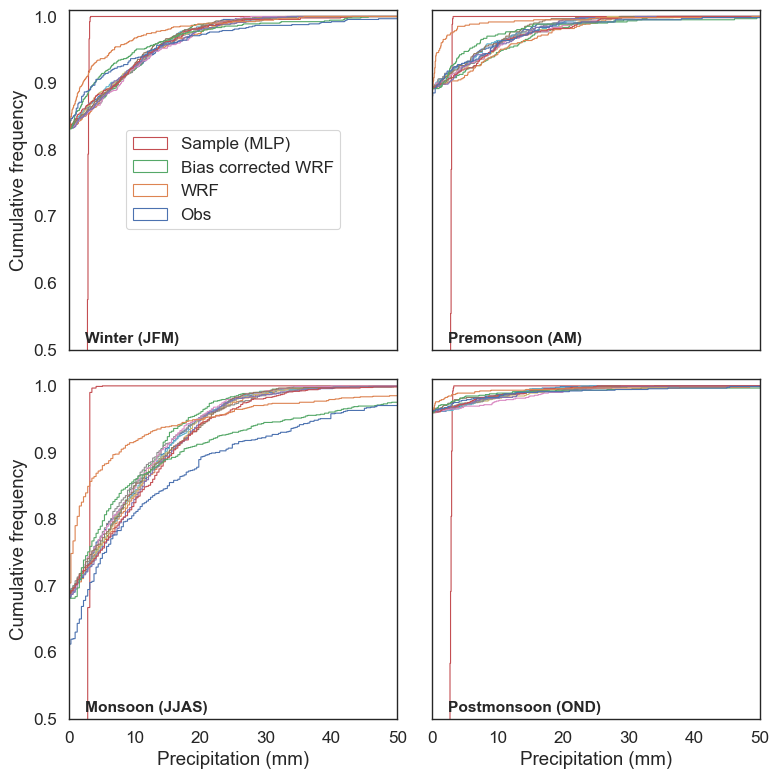

In [185]:
sns.set_theme(context='paper',style='white',font_scale=1.4)

x_hist = st_test[st_test['season']=='DJF'][columns].to_numpy()
n_bins = 1000

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

stations = st_test['Station'].unique()
random_station = np.random.randint(len(stations))
st_test_station = st_test[st_test['Station']==stations[random_station]]
print(st_test_station['Station'].unique())

for idx, ax in enumerate(axes.flatten()):

    x_hist = st_test_station[st_test_station['season']==seasons[idx]][columns].to_numpy()
    ax.hist(x_hist, n_bins, density=True, cumulative=True, histtype='step', label=labels)
    
    ax.set_ylim([0.5,1.01]) 
    ax.set_xlim([0,50])
    ax.set_xlabel('Precipitation (mm)') if idx>1 else None
    ax.set_ylabel('Cumulative frequency') if idx%2==0 else None
    ax.set_xticklabels([]) if not(idx>1) else None
    ax.set_yticklabels([]) if not(idx%2==0) else None
    
    ax.text(0.05, 0.02, f'{seasons[idx]}', fontweight="bold", transform=ax.transAxes, size='small')
    
    if idx==0:
        ax.legend(loc='center')

plt.tight_layout()
plt.show()

In [186]:
print(f"=========== KS scores for {stations[random_station]} station ============")
for season in seasons:
    print(f"--- {season} ---")
    for col in columns[1:]:
        rvs = st_test_station[st_test_station['season']==season]['Prec']
        cdf = st_test_station[st_test_station['season']==season][col]
        #kstest = scipy.stats.kstest(rvs, cdf, args=(), N=20, alternative='two-sided', mode='auto')
        kstest = scipy.stats.ks_2samp(rvs, cdf, alternative='two-sided', mode='auto')
        print(f"{col} : {kstest.statistic:.4f}")

=========== KS scores for Daslehra station ============
--- Winter (JFM) ---
wrf_prcp : 0.0333
wrf_bc_prcp : 0.0155
sample_0 : 0.0277
sample_1 : 0.0366
sample_2 : 0.0344
sample_3 : 0.0388
sample_4 : 0.0355
sample_5 : 0.0289
sample_6 : 0.0322
sample_7 : 0.0300
sample_8 : 0.0400
sample_9 : 0.0411
mean : 0.8868
--- Premonsoon (AM) ---
wrf_prcp : 0.0607
wrf_bc_prcp : 0.0262
sample_0 : 0.0148
sample_1 : 0.0197
sample_2 : 0.0131
sample_3 : 0.0131
sample_4 : 0.0115
sample_5 : 0.0131
sample_6 : 0.0148
sample_7 : 0.0115
sample_8 : 0.0246
sample_9 : 0.0164
mean : 0.9180
--- Monsoon (JJAS) ---
wrf_prcp : 0.1713
wrf_bc_prcp : 0.0689
sample_0 : 0.0770
sample_1 : 0.0738
sample_2 : 0.0779
sample_3 : 0.0746
sample_4 : 0.0811
sample_5 : 0.0779
sample_6 : 0.0779
sample_7 : 0.0721
sample_8 : 0.0770
sample_9 : 0.0820
mean : 0.6836
--- Postmonsoon (OND) ---
wrf_prcp : 0.0163
wrf_bc_prcp : 0.0065
sample_0 : 0.0065
sample_1 : 0.0076
sample_2 : 0.0054
sample_3 : 0.0120
sample_4 : 0.0076
sample_5 : 0.0065
samp

['Nadaun']


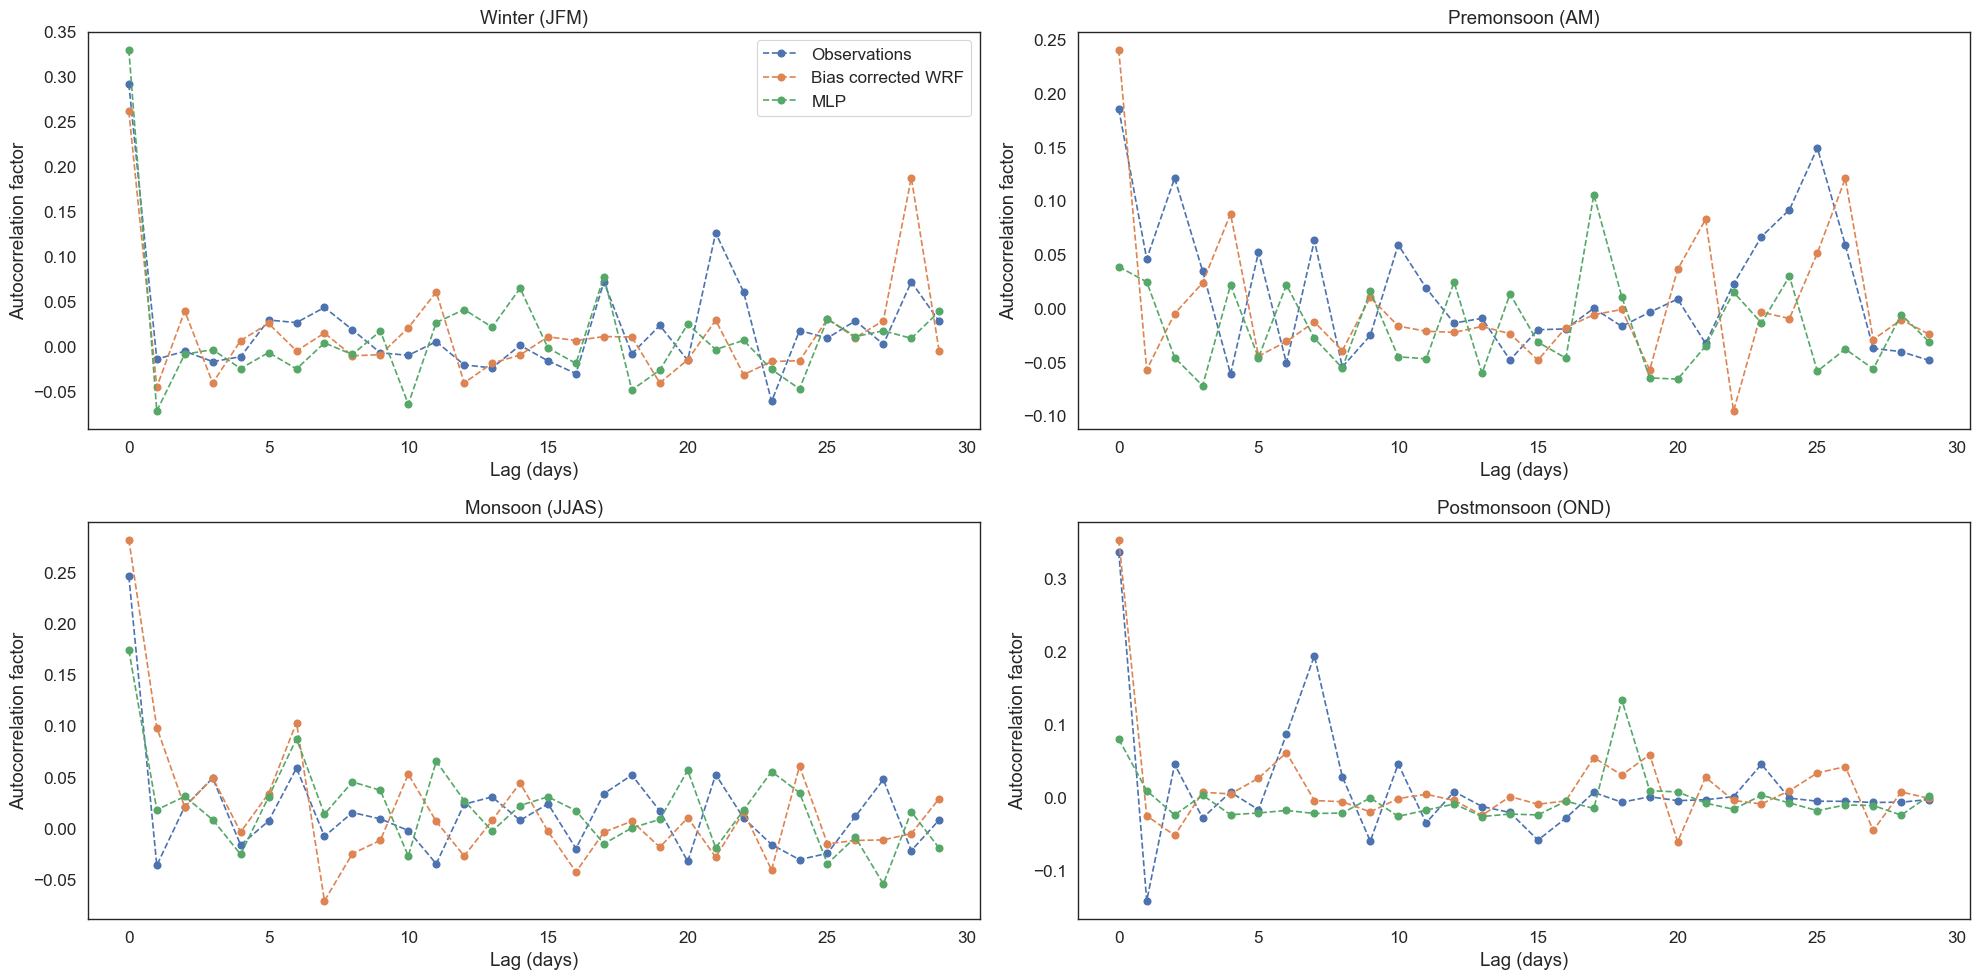

In [363]:
acf_dict = {}
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

stations = st_test['Station'].unique()
random_station = np.random.randint(len(stations))
st_test_station = st_test[st_test['Station']==stations[random_station]]
print(st_test_station['Station'].unique())

fig, axes = plt.subplots(2, 2, figsize=(20,10))

for index, ax in enumerate(axes.flatten()):

    for col in list(np.array(columns)[[0,2,3]]):
        
        x = st_test_station[st_test_station['season']==seasons[index]][col]
        
        if seasons[index] not in acf_dict:
            acf_dict[seasons[index]] = {}
            
        y = acf_dict[seasons[index]][col] = sm.tsa.pacf(x,nlags=30)
        
        ax.plot(y[1:], 'o--', label="col")
        
#         plot_pacf(x,
#                 ax=ax,
#                 use_vlines=False,
#                 alpha=1,
#                 zero=False,
#                 title=seasons[index])
        
    ax.set_xlabel("Lag (days)")
    ax.set_ylabel("Autocorrelation factor")
    ax.set_title(seasons[index])

    if index==0:
        pass
        ax.legend(["Observations","Bias corrected WRF","MLP"])
        #ax.legend(columns[0:3])

#plt.suptitle(f"Autocorrelation factors by season (test station: {st_test_station['Station'].unique()}) ")

plt.tight_layout()
plt.show()

In [188]:
for season in seasons:
    print(f'--- {season} ---')
    for col in list(np.array(columns)[[2,3]]):
        p = acf_dict[season]['Prec']
        q = acf_dict[season][col]
        #kl_divergence(p,q)
        rmse = np.mean((p - q)**2)
        max_diff = np.max(abs(p-q))
        print(f'{col} : {max_diff:.3f}') 

--- Winter (JFM) ---
wrf_bc_prcp : 0.075
sample_0 : 0.098
--- Premonsoon (AM) ---
wrf_bc_prcp : 0.128
sample_0 : 0.124
--- Monsoon (JJAS) ---
wrf_bc_prcp : 0.098
sample_0 : 0.112
--- Postmonsoon (OND) ---
wrf_bc_prcp : 0.129
sample_0 : 0.134


## Multi-Run: Train model with different hyperparameters

In [61]:
params = OrderedDict(
    lr = [0.005]
    ,batch_size = [128]
    ,likelihood_fn = ['gamma','b2gmm']
    ,hidden_channels = [['VGLM']] #[[10],[30],[50],[100],[10,10],[30,30],[50,50],[100,100]]
    ,dropout_rate = [0]
    ,linear_model = [True] #['True','False']
    #,k = [0]
    ,k = list(range(10))
)

epochs = 10

In [932]:
# df1 = pd.read_csv('results_1.csv', index_col='Unnamed: 0')
# df2 = pd.read_csv('results_2.csv', index_col='Unnamed: 0')
# df3 = pd.read_csv('results_3.csv', index_col='Unnamed: 0')
# df4 = pd.read_csv('results_4.csv', index_col='Unnamed: 0')
# df5 = pd.read_csv('results_5.csv', index_col='Unnamed: 0')

In [970]:
# df11 = df1.loc[(df1.likelihood_fn != 'b2gmm') | (df1.linear_model == True) | (df1.hidden_channels != '[100, 100]')].copy()
# df22 = df2.loc[(df2.hidden_channels != '[100, 100]')].copy()
# df33 = df3.copy()
# df44 = df4.copy()
# df55 = df5.copy()

In [974]:
# df = df11.append(df22).append(df33).append(df44).append(df55)
# df.to_csv('results.csv')

In [1226]:
# with open('data_split.pickle', 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [62]:
m = RunManager()
predictions={}

for run in RunBuilder.get_runs(params): 
    
    d = len(predictors)
    
    network = MLP(in_channels=d, 
            hidden_channels=run.hidden_channels, 
            likelihood_fn=run.likelihood_fn,
            dropout_rate=run.dropout_rate,
            linear_model=True,
            )
    
    train_tensor_x = torch.Tensor(data[f'X_train_{run.k}'][:,:d]) # transform to torch tensor
    train_tensor_y = torch.Tensor(data[f'Y_train_{run.k}'][:,:d]) # transform to torch tensor
    train_dataset = TensorDataset(train_tensor_x,train_tensor_y) # create training dataset

    val_tensor_x = torch.Tensor(data[f'X_val_{run.k}'][:,:d]) # transform to torch tensor
    val_tensor_y = torch.Tensor(data[f'Y_val_{run.k}'][:,:d]) # transform to torch tensor
    val_dataset = TensorDataset(val_tensor_x,val_tensor_y) # create test dataset
    
    test_tensor_x = torch.Tensor(data[f'X_test_{run.k}'][:,:d]) # transform to torch tensor
    test_tensor_y = torch.Tensor(data[f'Y_test_{run.k}'][:,:d]) # transform to torch tensor
    test_dataset = TensorDataset(test_tensor_x,test_tensor_y) # create test dataset
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=run.batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=run.batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=run.batch_size, shuffle=False)
    
    optimizer = torch.optim.Adam(network.parameters(), lr=run.lr)
    
    change_folder = True
    if change_folder:
        experiment_name = f'{run}'
        wd = WorkingDirectory(generate_root(experiment_name))
    
    m.begin_run(run, network, train_loader)
    
    train_losses = []
    val_losses = []
    
    for epoch in range (epochs):
        
        m.begin_epoch()
        
        train_loss, val_loss, _ = train_epoch(network, 
                                             optimizer, 
                                             train_loader, 
                                             val_loader, 
                                             epoch=epoch, 
                                             print_progress=True)
                
        m.epoch_loss = train_loss
        m.epoch_val_loss = val_loss
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
            
        m.end_epoch()
        
        save_as_best = True if val_loss == min(val_losses) else False
        save_checkpoint(wd,network.state_dict(),is_best=save_as_best)
    
        PATH = os.path.join(wd.root,'e_%s_loss_%.3f.pth.tar' % (epoch, val_loss))
        torch.save(network.state_dict(), PATH)
        
    load_best = True
    if load_best:
        network.load_state_dict(torch.load(os.path.join(wd.root,'model_best.pth.tar')))
        
    with torch.no_grad():
        outputs = network(test_tensor_x)
        # outputs = network(val_tensor_x)
    
    if split_by == 'year':
        input_df = st[(st['Year'].isin(split_dict[f'k{run.k}']['test']))] 
        input_st_names = None
    elif split_by == 'station':
        input_df = st
        input_st_names = split_dict[f'k{run.k}']['test']
        
    st_test = build_results_df(df=input_df,
                              outputs=outputs, 
                              st_names_test=input_st_names,                 
                              model=network,
                              draw_samples=True,
                              n_samples=10,
                              confidence_intervals= True,
                              )
    
    key = f'{run.likelihood_fn}_{run.hidden_channels}_{run.linear_model}'
    
    if not(key in predictions.keys()):
        predictions[key] = {} 
        
    predictions[key][f'k{run.k}'] = st_test
    
    SAVEPATH = os.path.join(wd.root, "st_test.pkl")
    st_test.to_pickle(SAVEPATH)
    
    m.end_run()    
    
m.save('results')

,run,epoch,loss,valid_loss,epoch duration,run duration,lr,batch_size,likelihood_fn,hidden_channels,dropout_rate,linear_model,k
0,1,1,-5.006635,-6.376898,1.601921,1.603022,0.005,128,gamma,[VGLM],0,True,0
1,1,2,-6.936982,-6.584534,1.582280,3.206933,0.005,128,gamma,[VGLM],0,True,0
2,1,3,-6.973628,-6.597708,1.440218,4.669535,0.005,128,gamma,[VGLM],0,True,0
3,1,4,-6.973876,-6.597551,1.437674,6.133092,0.005,128,gamma,[VGLM],0,True,0
4,1,5,-6.973389,-6.596884,1.481023,7.638375,0.005,128,gamma,[VGLM],0,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,20,6,1.142509,1.311377,2.645050,15.945558,0.005,128,b2gmm,[VGLM],0,True,9
196,20,7,1.142692,1.307436,2.539522,18.514453,0.005,128,b2gmm,[VGLM],0,True,9
197,20,8,1.142205,1.311756,2.487535,21.033769,0.005,128,b2gmm,[VGLM],0,True,9
198,20,9,1.142166,1.307458,2.629192,23.693465,0.005,128,b2gmm,[VGLM],0,True,9


In [205]:
df = pd.read_csv('results.csv', index_col='Unnamed: 0')

In [64]:
for run in predictions.keys():
    for i in range(len(params['k'])):
        predictions[run][f'k{i}']['k_fold'] = i
        if i == 0:
            predictions[run]['k_all'] = predictions[run][f'k{i}']
        else:
            predictions[run]['k_all'] = predictions[run]['k_all'].append(predictions[run][f'k{i}'])

In [226]:
loglik_meanvalues = df.groupby(['likelihood_fn','hidden_channels','k','linear_model']).min()[['valid_loss']].groupby(['likelihood_fn','hidden_channels','linear_model']).mean().reset_index()

In [227]:
loglik_values = df.groupby(['likelihood_fn','hidden_channels','k','linear_model']).min()[['valid_loss']].reset_index()

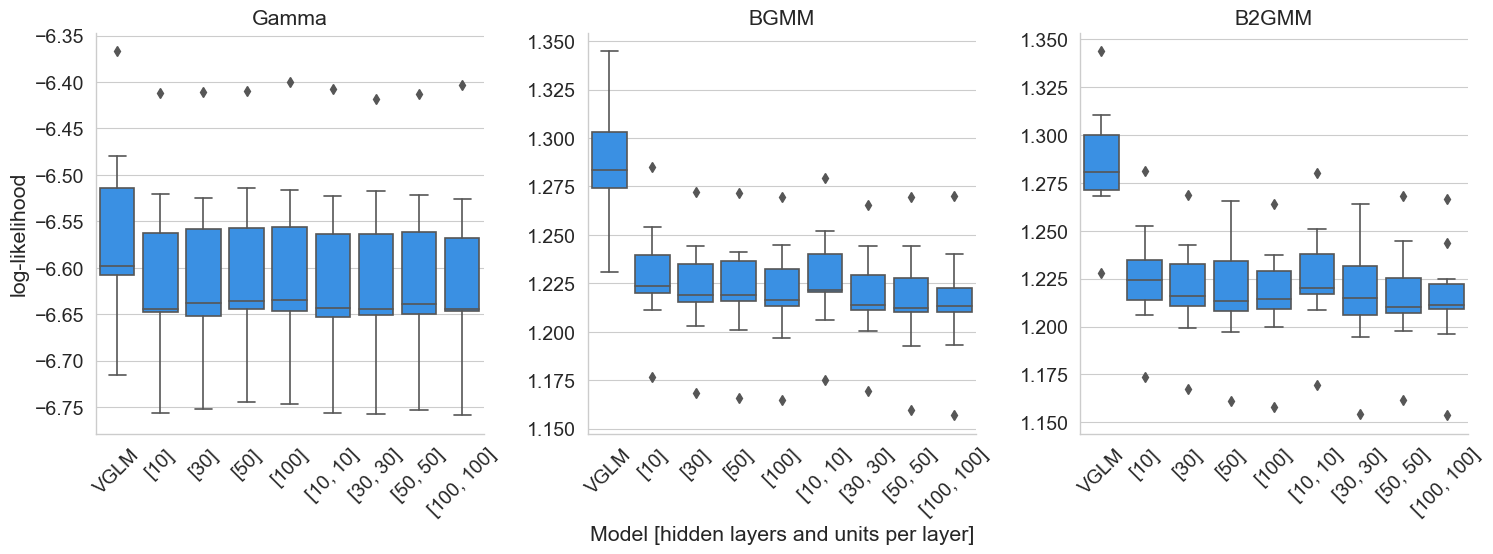

In [237]:
sns.set_theme(context='paper',style='whitegrid',font_scale=1.6)
g = sns.catplot(x = "hidden_channels",
            y = "valid_loss",
            #hue = "linear_model",
            col = "likelihood_fn",
            data = loglik_values,
            kind = "box",
            order=['VGLM','[10]','[30]','[50]','[100]','[10, 10]','[30, 30]','[50, 50]','[100, 100]'],
            col_order=['gamma','bgmm','b2gmm'],
            sharey = False,
            #split = True,
            #palette = 'Set2'
            color='dodgerblue'
           )

g.set_xticklabels(rotation=45)
g.set_ylabels('log-likelihood')

# leg = g.legend
# leg.set_title('')
# new_labels = ['Linear','MLP']
# for t, l in zip(leg.texts, new_labels): t.set_text(l)

titles = ['Gamma','BGMM','B2GMM']

for i, ax in enumerate(g.axes.flatten()):
    ax.set_title(titles[i]) 
#     ax.set_ylim(1.15,1.30) if i>0 else ax.set_ylim(-6.77,-6.35)
    ax.set_xlabel('Model [hidden layers and units per layer]') if i==1 else ax.set_xlabel('')

g.savefig('figures/loglik_comparison.png',dpi=300)
plt.show()

In [838]:
best = df.groupby(['likelihood_fn','hidden_channels','k','linear_model']).min()[['valid_loss']].reset_index().sort_values('valid_loss')
best
best.loc[(best['likelihood_fn'].isin(['bgmm','b2gmm'])) & (best['linear_model']==True)]

,likelihood_fn,hidden_channels,k,linear_model,valid_loss


In [841]:
sns.set_theme(context='paper',style='white',font_scale=1.4)

best = df.groupby(['likelihood_fn','hidden_channels','k','linear_model']).min()[['valid_loss']].reset_index().sort_values('valid_loss')
best = best.loc[(best['likelihood_fn'].isin(['bgmm','b2gmm'])) & (best['linear_model']==False)]

sns.boxplot(data=best,y='valid_loss',x='hidden_channels',hue='likelihood_fn')
plt.show()

ValueError: min() arg is an empty sequence

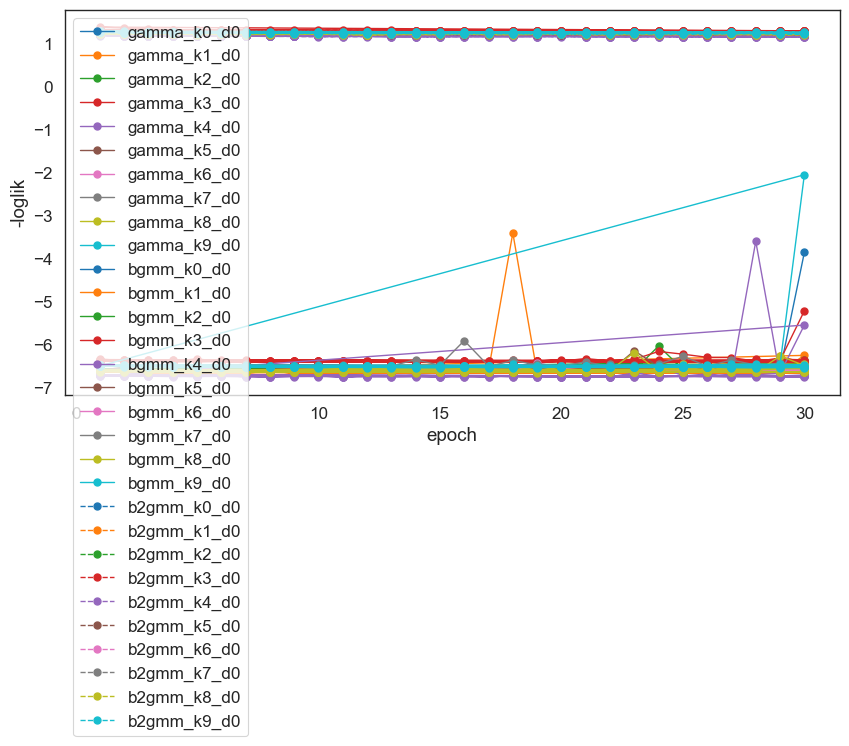

In [287]:
sns.set_theme(context='paper',style='white',font_scale=1.4)
plt.figure(figsize=(10,5))

linecolors = {"0" : "tab:blue",
              "1" : "tab:orange",
              "2" : "tab:green",
              "3" : "tab:red",
              "4" : "tab:purple",
              "5" : "tab:brown",
              "6" : "tab:pink",
              "7" : "tab:grey",
              "8" : "tab:olive",
              "9" : "tab:cyan"}

linestyles = {"bgmm" : "solid",
             "b2gmm" : "dashed",
             "gamma" : "solid"}

markerstyles = {"0" : "o",
                "0.2" : "x",
                "0.3" : "^",
                "0.4" : ">"}

style_dict = {"linestyles" : linestyles,
             "linecolors" : linecolors}

for a in df.likelihood_fn.unique():
    for b in df.k.unique():
        for d in df.dropout_rate.unique(): 
            c = df[(df.likelihood_fn == a) & (df.k == b) & (df.dropout_rate == d)].copy()
            plt.plot(c.epoch, 
                     c.valid_loss, 
                     label=f'{a}_k{b}_d{d}', 
                     linestyle=linestyles[a],
                     color = linecolors[str(b)],
                     marker = markerstyles[str(d)],
                     linewidth = 1,
                     markersize = 5
                    )

plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('-loglik')
plt.tight_layout
plt.show()

### Sample from 2-Gamma mixture model and plot

In [ ]:
# %%time
# k = 1
# bins = 1000
# hist_max = 50
# r = np.random.randint(outputs.shape[0], size=k)
# print(r)
# dist = gmm_fn(pi=outputs[r,0],
#             alpha1=outputs[r,1],
#             alpha2=outputs[r,2],
#             beta1=outputs[r,3],
#             beta2=outputs[r,4],
#             q=outputs[r,5],
#             )

# plt.figure(figsize=(15,5))
# plt.plot(np.linspace(0,hist_max,bins),(torch.histc(dist.sample([1000000]), bins=bins, min=0, max=hist_max)))
# plt.plot(dist.mean,np.zeros(k),'or')
# plt.plot(test_tensor_y[r],np.zeros(k),'xk',ms=10)
# plt.show()

### Sample from Bernoulli-Gamma mixture model

In [118]:
interval=5

flag = 0
if flag:

    while True:

        x = np.linspace (0, 100, 200) 
        r = np.random.randint(len(inputs))
        print(r)

        pi = outputs[r,0]
        a = outputs[r,1]
        rate = outputs[r,2]

        y1 = stats.gamma.cdf(x, a=a, scale=1/rate) #a is alpha, loc is beta???

        mu = stats.gamma.mean(a=a, scale=1/rate)
        median = stats.gamma.median(a=a, scale=1/rate)
        mixture_median = stats.gamma.ppf((0.5 - pi) / (1 - pi), a=a, scale=1/rate) if pi < 0.5 else 0
        mixture_mean = (1-pi) * mu

        print("mean: %.2f" % mu)
        print("median: %.2f" % median)
        print("mixture median: %.2f" % mixture_median)
        print("mixture mean: %.2f" % mixture_mean)

        modelled = inputs[r,0]*x_std[0] + x_mean[0]
        observed = tensor_y[r,0]

        if modelled > 0:

            #mu = a/rate if pi<0.5 else 0

            plt.plot(0,pi,"oy", label="pi = %.2f" % pi)

            plt.plot(mu, 0, "or", mfc="white", label="mu = %.2f" % mu)
            plt.plot(median, 0, "xr", label="median = %.2f" % median)  
            plt.plot(mixture_median, 0, "ok", mfc="white", label="mixture median = %.2f" % mixture_median)  
            plt.plot(mixture_mean, 0, "^k", label="mixture median = %.2f" % mixture_mean)  

            plt.plot(modelled, 0, "x", label="WRF = %.2f" % modelled)

            plt.plot(observed, 0, "xg", label="observed = %.2f" % observed)
            plt.plot(x, pi + (1-pi)*y1, "y-", label=(r'$\alpha=%.2f, \beta=%.2f$') % (a, rate))

            plt.ylim([-0.05,1])
            plt.xlim([-0.2, max([1,modelled,observed,mu])*1.20])
            plt.legend(loc="upper right")
            plt.show()

            time.sleep(interval)

        else:
            pass

        clear_output(wait=True)

### Plot time series of predictions

In [586]:
p=0.05
multirun=True

if multirun:
    likelihood_fn = 'bgmm'
    st_test = predictions[likelihood_fn]['k_all']
else:
    likelihood_fn = model.likelihood

KeyError: 'pi'

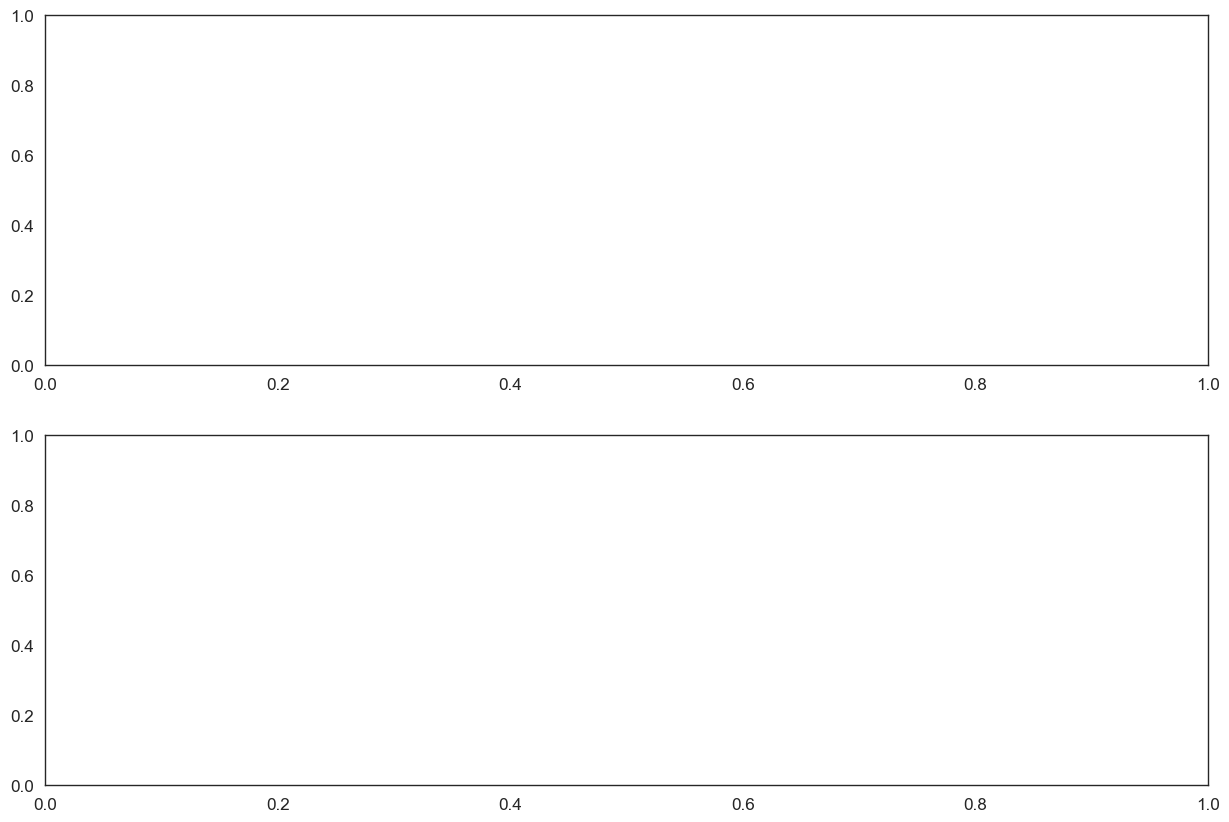

In [190]:
df = st_test[st_test['Station']=='Pandoh']
df = clip_time_period(df,'2003-01-01','2003-12-31')

fig,[ax1,ax2] = plt.subplots(2,1,figsize=(15,10))
ax1.plot(df['pi'],label='pi')
ax1.plot(df['alpha'],label='alpha')
ax1.plot(df['beta'],label='beta')
ax1.legend()
ax2.plot(df['wrf_prcp'],label='wrf')
ax2.plot(df['Prec'],label='obs')
ax2.legend()
plt.tight_layout()
plt.show()

Rampur


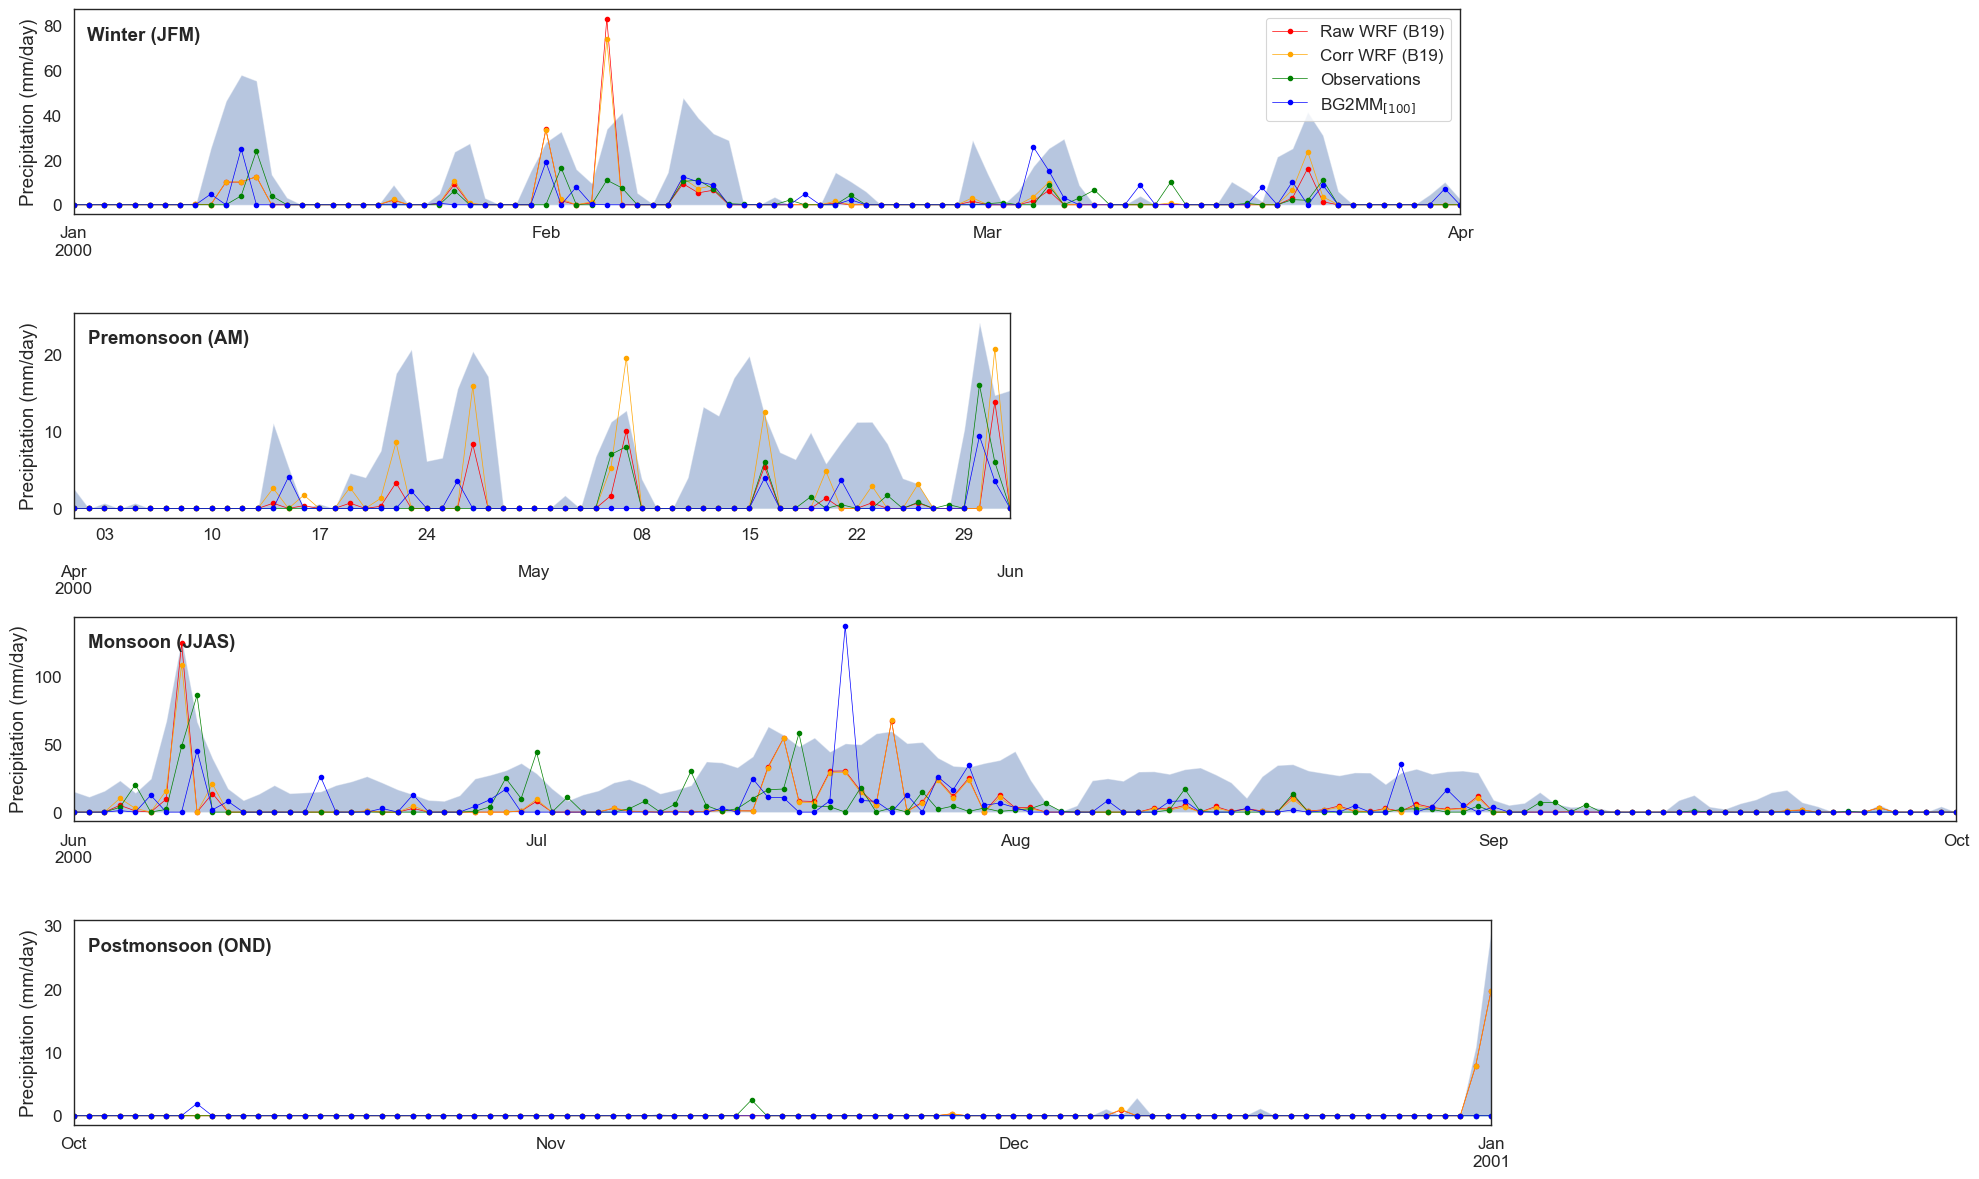

In [405]:
sns.set_theme(context='paper', style='white', font_scale=1.4)

#fig, axes = plt.subplots(4,1,figsize=(20,13))

year = 2000

test_station_names = st_test['Station'].unique()
random_index = np.random.randint(len(test_station_names))
random_station = test_station_names[random_index]


random_station = 'Rampur'
print(random_station)


st_test_r = st_test[st_test['Station']==random_station].copy()
st_test_r['sample'] = st_test_r['sample_0']

fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(20)

ax1 = plt.subplot2grid(shape=(4, 122), loc=(0, 0), colspan=90)
ax2 = plt.subplot2grid(shape=(4, 122), loc=(1, 0), colspan=61)
ax3 = plt.subplot2grid(shape=(4, 122), loc=(2, 0), colspan=122)
ax4 = plt.subplot2grid(shape=(4, 122), loc=(3, 0), colspan=92)

for index, ax in enumerate([ax1,ax2,ax3,ax4]):
        
    if index == 0:
        xmin = f"{year}-01-01"
        xmax = f"{year}-04-01" 
    elif index == 1:
        xmin = f"{year}-04-01"
        xmax = f"{year}-06-01" 
    elif index == 2:
        xmin = f"{year}-06-01"
        xmax = f"{year}-10-01"
    elif index == 3:
        xmin = f"{year}-10-01"
        xmax = f"{year+1}-01-01" 
    
    show_legend = True if index == 0 else False

    plot_timeseries(st_test_r, 
                    likelihood_fn='b2gmm',
                    xmin = xmin,
                    xmax = xmax,
                    show_mean=False,
                    show_median=False, 
                    show_median_gamma=False,
                    show_confidence=True,
                    show_sample=True,
                    complete_title=False,
                    show_legend=show_legend,
                    ax=ax
                    )
    
    if show_legend:
        leg = ax.get_legend()
        new_labels = ['Raw WRF (B19)', 'Corr WRF (B19)','Observations','BG2MM$_{[100]}$']
        leg.set_title('')
        for t, l in zip(leg.texts, new_labels): t.set_text(l)

        


    
    x_pos = [0.01, 0.015, 0.0075, 0.01]
    ax.text(x_pos[index], 0.85, f'{seasons[index]}', fontweight="bold", transform=ax.transAxes)

plt.tight_layout(w_pad=-0.5)
plt.savefig(f"figures/timeseries_seasons_{random_station}_{year}.png", dpi=300)
plt.show()

### Print summary of results

In [ ]:
print_summary_of_results(st_test, likelihood_fn, alldays=True, drydays=True, wetdays=True, wet_threshold=50)

In [ ]:
day_filter = 'alldays'
p_threshold = 50

if day_filter=='drydays':
    st_test_summary = st_test[st_test['Prec']==0].groupby('Station').mean()
elif day_filter=='wetdays':
    st_test_summary = st_test[st_test['Prec']>=p_threshold].groupby('Station').mean()
elif day_filter=='alldays':
    st_test_summary = st_test.groupby('Station').mean()

#st_test_summary.drop(columns=['Altitude (m)', 'Prec', 'model_precipitation', 'doy', 'doy_cos', 'doy_sin'], inplace=True)

st_test_summary['se_mlp_ratio'] = 1 - st_test_summary['se_mlp']/st_test_summary['se_wrf']
st_test_summary['se_mlp_median_ratio'] = 1 - st_test_summary['se_mlp_median']/st_test_summary['se_wrf']
st_test_summary['se_mlp_median_gamma_ratio'] = 1 - st_test_summary['se_mlp_median_gamma']/st_test_summary['se_wrf']
st_test_summary['se_reg_ratio'] = 1 - st_test_summary['se_bcp']/st_test_summary['se_wrf']

In [ ]:
plt.figure(figsize=(8,8))
plt.style.use('seaborn-dark-palette')
plt.plot(st_test_summary['Z'],st_test_summary['se_mlp_ratio'],'og', label='$\mu$ - Neural Network (Bernoully Gamma mixture model)')
plt.plot(st_test_summary['Z'],st_test_summary['se_mlp_median_ratio'],'xb', label='$median$ - Neural Network (Bernoully Gamma mixture model)')
plt.plot(st_test_summary['Z'],st_test_summary['se_mlp_median_gamma_ratio'],'>k', label='$median$ $\Gamma$ - Neural Network (Bernoully Gamma mixture model)')

plt.plot(st_test_summary['Z'],st_test_summary['se_reg_ratio'],'or', label='Bannister et al. (2019)')

plt.xlabel("Elevation (masl)")
plt.ylabel("MSE reduction ratio")
plt.ylim([-1, 1])
plt.legend()
#plt.savefig(f"exports/MSE_plot_{day_filter}.png")
plt.show()

In [ ]:
"""plt.figure(figsize=(10,10))

plt.plot(st_test_r['Prec'], st_test_r['se_mlp'],'o',ms=4,label="MLP")
plt.plot(st_test_r['Prec'], st_test_r['se_wrf'],'x',ms=4,label="WRF")

plt.legend()

#plt.ylim([-0,20000])
plt.show()""";

In [523]:
path = '../../PhD/gis/exports/beas_watershed.shp'
beas_watershed = geopandas.read_file(path)

path = '../../PhD/gis/exports/sutlej_watershed.shp'
sutlej_watershed = geopandas.read_file(path)

In [546]:
import rasterio
from rasterio.plot import show

In [542]:
stations_df_train = st[st['Station'].isin(st_names_dict['train'])].groupby(['Station']).mean()
stations_df_train = stations_df_train[['X','Y']]

stations_df_val = st[st['Station'].isin(st_names_dict['val'])].groupby(['Station']).mean()
stations_df_val = stations_df_val[['X','Y']]

#gdf = build_geodataframe(st_test_summary, x='X', y='Y')
gdf = build_geodataframe(st_test.groupby('Station').mean(), x='X', y='Y')

#gdf_train = build_geodataframe(stations_df_train, x='X', y='Y')
#gdf_val = build_geodataframe(stations_df_val, x='X', y='Y')

out_fp_masked_lcc = r'/Users/marron31/Google Drive/PhD/srtm/mosaic_masked_lcc.tif'
dem_masked_lcc = rasterio.open(out_fp_masked_lcc)


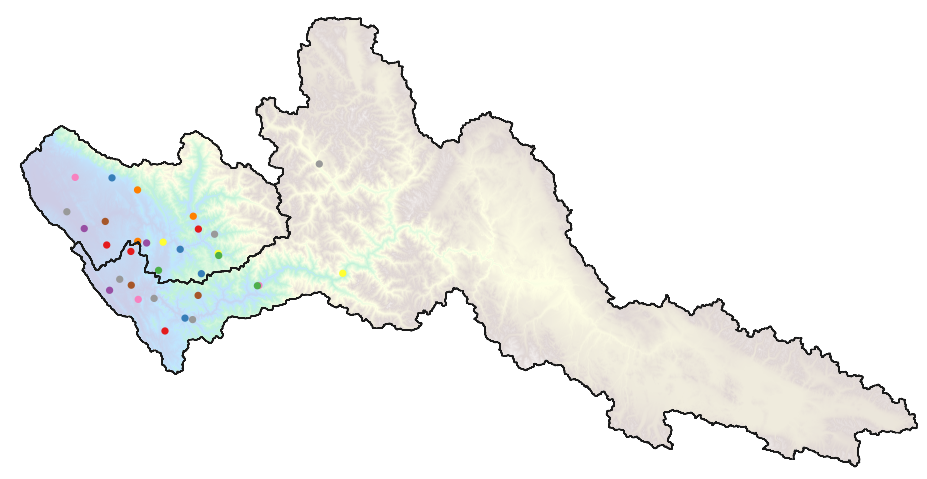

In [555]:
fig, ax = plt.subplots(1, 1, figsize=(10,5), constrained_layout=False)
gdf.plot(ax=ax, column='k_fold', legend=False, cmap='Set1', markersize=5, marker="o", linewidth=3)
show(dem_masked_lcc, cmap='terrain', ax=ax, alpha=0.25)
beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=1)
sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=1)
ax.set_axis_off()
ax.set_aspect(1)
plt.tight_layout()
plt.savefig('figures/kfold_cv_map.png',dpi=300)
plt.show()

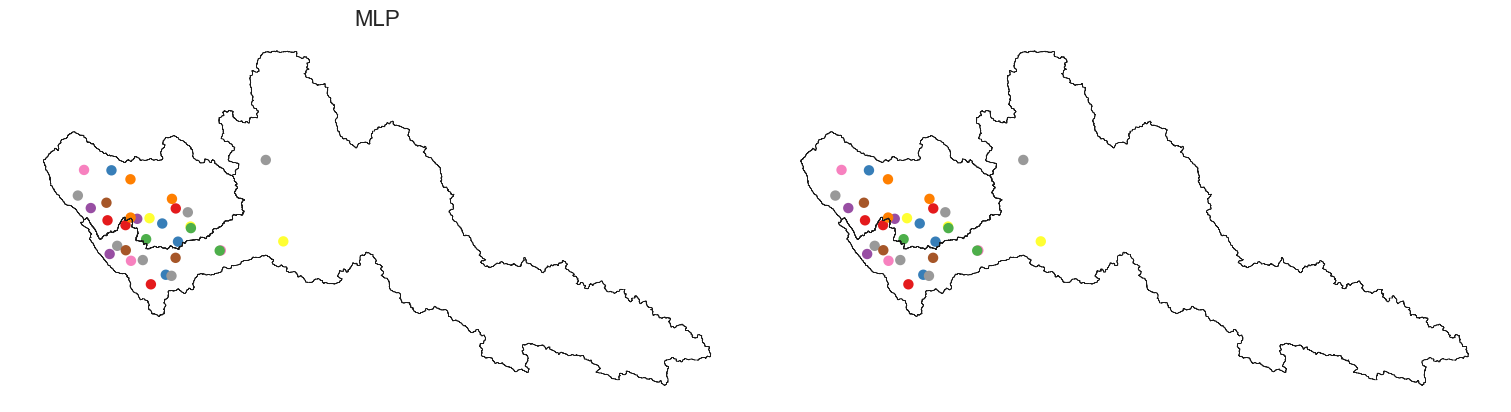

In [527]:
fig, axes = plt.subplots(1, 2, figsize=(15,10), constrained_layout=True)
#color_map = plt.cm.get_cmap('seismic').reversed()
margin = 0.25

for i, ax in enumerate(axes):
    gdf.plot(ax=ax, column='k_fold', legend=False, cmap='Set1', markersize=20, marker="o", linewidth=3)
    beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    #if i==len(axes)-1:
    #    plt.colorbar(plt.cm.ScalarMappable(cmap='Set1'), ax=ax, shrink=0.6)
    #ax.set_xlim(gdf.X.min() - margin*(gdf.X.max() - gdf.X.min()), gdf.X.max() + margin*(gdf.X.max() - gdf.X.min()))
    #ax.set_ylim(gdf.Y.min() - margin*(gdf.Y.max() - gdf.Y.min()), gdf.Y.max() + margin*(gdf.Y.max() - gdf.Y.min()))
    #ax.set_ylabel(" ")
    #ax.set_xlabel(" ")
    ax.set_axis_off()
    ax.set_aspect(1)

#axes[0].scatter(gdf.X, gdf.Y, c=gdf.se_mlp_ratio, cmap=color_map)
#gdf.plot(ax=axes[0], column='se_mlp_ratio',legend=True, edgecolor = 'white',  cmap=color_map,  markersize=100, vmin=-1, vmax=1)
axes[0].set_title('MLP', fontsize=16)
#gdf.plot(ax=axes[1], column='se_reg_ratio',legend=True, edgecolor = 'white', cmap=color_map,  markersize=100, vmin=-1, vmax=1)
#axes[1].set_title('Bannister et al. (2019)', fontsize=16)

#plt.legend()
#plt.tight_layout()
plt.show()

#plt.savefig(likelihood_fn+'.png');

In [314]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import AxesGrid
# import numpy as np
# plt.style.use('seaborn-dark-palette')

# title = ['$\mu$ Neural Network', '$median$ Neural Network', '$median$ $\Gamma$ Neural Network', 'Bannister et al. (2019)']
# var = ['se_mlp_ratio', 'se_mlp_median_ratio', 'se_mlp_median_gamma_ratio', 'se_reg_ratio']

# fig = plt.figure(figsize=(20, 20))

# color_map = plt.cm.get_cmap('seismic').reversed()

# grid = AxesGrid(fig, 111,
#                 nrows_ncols=(2, 2),
#                 #aspect=False,
#                 axes_pad=0,
#                 cbar_mode='single',
#                 cbar_location='right',
#                 cbar_pad=0.05,
#                 cbar_size="2.5%"
#                 )

# for i, ax in enumerate(grid):
#     ax.set_axis_off()
#     ax.set_yticks([])
#     ax.set_xticks([])
    
#     #ax.set_xlim(gdf.X.min() - margin*(gdf.X.max() - gdf.X.min()), gdf.X.max() + margin*(gdf.X.max() - gdf.X.min()))
#     #ax.set_ylim(gdf.Y.min() - margin*(gdf.Y.max() - gdf.Y.min()), gdf.Y.max() + margin*(gdf.Y.max() - gdf.Y.min()))
    
#     beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
#     sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
    
#     if i==0:
#         pass
#         #gdf_train.plot(ax=ax, markersize=15, color='green')
#         #gdf_val.plot(ax=ax, markersize=15, color='orange')
    
#     sc = ax.scatter(gdf.X, gdf.Y, 
#                     c=gdf['k_fold'],#[var[i]], 
#                     s=100, marker='p', cmap=color_map, vmin=-1, vmax=1, edgecolor='k')
#     ax.set_title(title[i], fontsize=15)
    
# # when cbar_mode is 'single', for ax in grid, ax.cax = grid.cbar_axes[0]
# cbar = grid.cbar_axes[0].colorbar(sc)
# cbar.ax.set_yticks([-1,0,1])
# cbar.ax.tick_params(labelsize=15)
# #plt.savefig(f'exports/{likelihood_fn}_{np.random.randint(1000)}.png')
# plt.show()

In [282]:
# fig, ax = plt.subplots(1, 1, figsize=(10,10))
# gdf.plot(ax=ax, column='k_fold', legend=False, cmap='Set1', markersize=20, marker="o", linewidth=3)
# beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
# sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=0.5)
# ax.set_axis_off()
# plt.savefig(f'exports/k_fold_{likelihood_fn}_{np.random.randint(1000)}.png')
# plt.show()

NameError: name 'map_results' is not defined

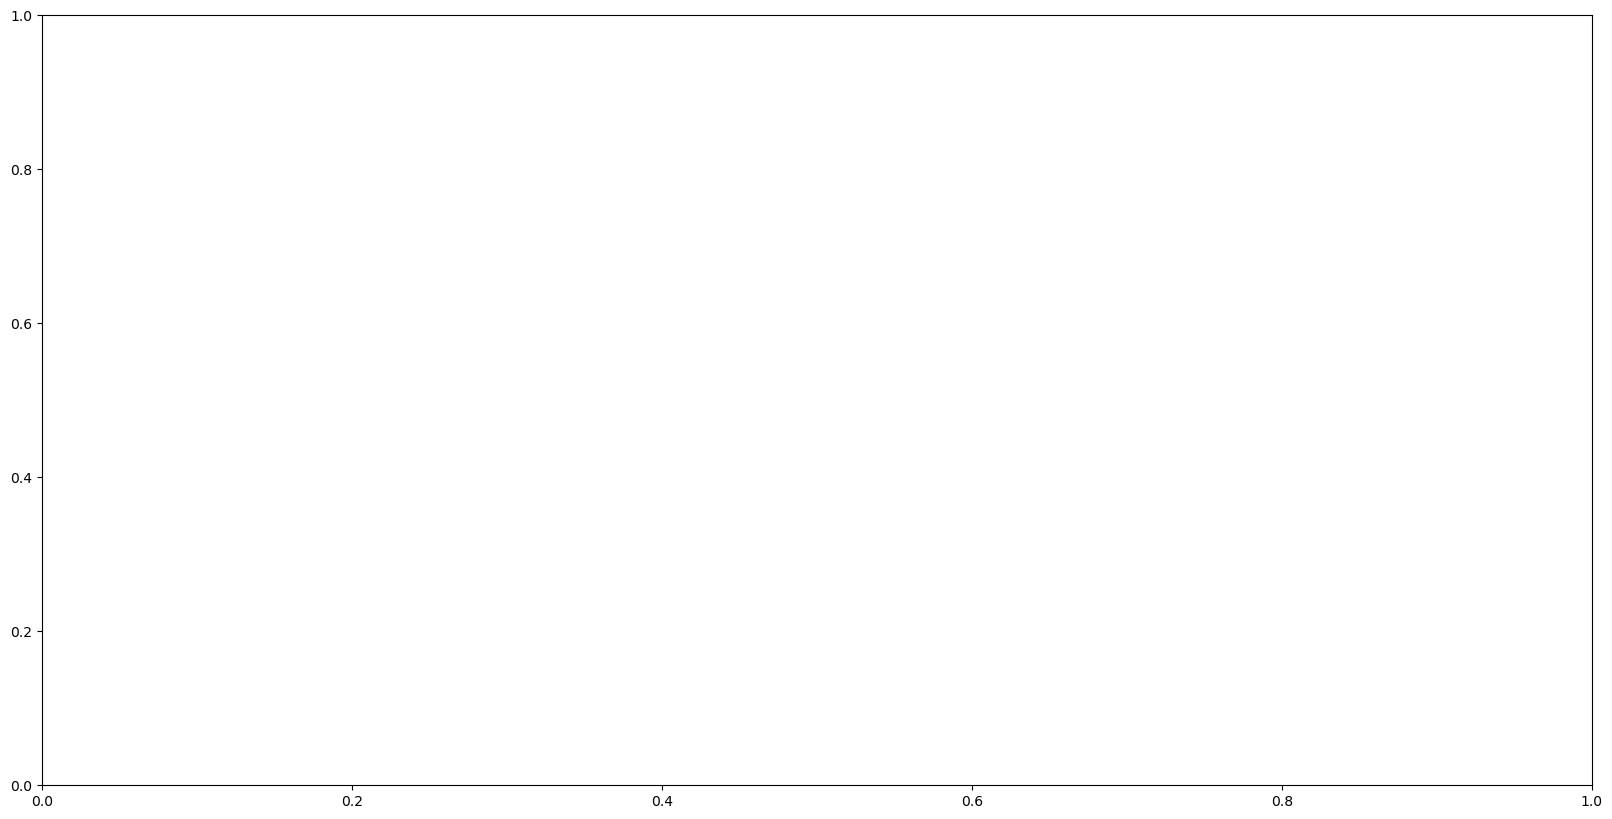

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(x=map_results['X'],y=map_results['Y'],c=map_results['Z'], cmap='Blues', marker='s')
beas_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=1)
sutlej_watershed.plot(ax=ax, edgecolor='k', color='None', linewidth=1)
ax.set_yticks([]), ax.set_xticks([])
ax.set_frame_on(False)
#     ax.scatter(x=st.X, y=st.Y, s=5)
#     scatter = ax.scatter(x=st_test.X, y=st_test.Y, c=st_test['k_fold'],cmap='Paired',s=50, marker='p')
    
#     legend1 = ax.legend(*scatter.legend_elements(),loc="lower left", title="CV class")
#     ax.add_artist(legend1)
    
plt.show()
    #plt.tight_layout()